# Three jump specification

- first two: change of $\vartheta$ 

    $\vartheta = 0.453$ and $\lambda = 0.1206$,
    
    - to $\frac12 \vartheta$, $\vartheta  = 0.0260$, $\lambda = 0.0798$
    - to 0, no emission

- Third jump, damage jump

In [39]:
# packages
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pandas as pd
import numpy as np
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
import time
from derivative import derivatives_2d
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
from scipy.interpolate import RegularGridInterpolator, CubicSpline
from multiprocessing import Pool

# from DICE_damage_tech import solve_postdmg, solve_predmg

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'


class GridInterp_2d():

    def __init__(self, grids, values, method = 'Linear'):

        # unpacking
        self.grids = grids
        (self.xs, self.ys) = grids
        self.nx = len(self.xs)
        self.ny = len(self.ys)
        
        self.values = values

        assert (self.nx, self.ny) == values.shape, "ValueError: Dimensions not match"
        self.method = method

    def get_value(self, x, y):

        if self.method == 'Linear':
            
            func = RegularGridInterpolator(self.grids, self.values)
            return func([x,y])[0]

        elif self.method == 'Spline':

            func1 = CubicSpline(self.xs, self.values)
            ySpace = func1(x)
            
            func2 = CubicSpline(self.ys, ySpace)
            return func2(y)

        else:
            raise ValueError('Method Not Supported')

In [2]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
# γ3_list = np.linspace(0, 1/3, 40)
# γ3_list = np.array([0, 0.0197*2, 0.3853*2])
y_bar = 2.3
y_jump = 2.
y_overline = 2.3
y = 2.5
damage_min = γ1*(y - y_jump+2) + γ2/2*(y - y_jump+2)**2
damage_max = γ1*(y - y_jump+2) + γ2/2*(y - y_jump+2)**2 + 1/3/2*(y - y_jump)**2
damages = np.linspace(np.exp(-damage_max), np.exp(-damage_min), 10)
γ3_list = 2*(- np.log(damages) - γ1*(y - y_jump+2) -
             γ2/2*(y - y_jump+2)**2)/(y - y_jump)**2
γ3_list = np.flip(γ3_list)
γ3_list[0] = 0

dmg_weight = np.ones(len(γ3_list))/len(γ3_list)
# capital parameters
invkap = 0.09
α = 0.115
μk = - 0.043
σk = 0.0085
κ = 6.667
k0 = 80/α

In [153]:
y_step = 0.1
y_grid = np.arange(0., 4.6 + y_step, y_step)

k_step = 0.2
k_grid = np.arange(0., 10. + k_step, k_step)

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing='ij')
stateSpace = np.hstack([y_mat.reshape(-1, 1, order='F'),
                       k_mat.reshape(-1, 1, order='F')])
hy = y_grid[1] - y_grid[0]
hk = k_grid[1] - k_grid[0]
n_y = len(y_grid)
n_k = len(k_grid)

In [154]:
def solve_parallel(args_list, func):
    with Pool() as p:
        res_list = p.starmap(func, args_list)
    return res_list

In [156]:
def solve_postdmg(y_grid,
                  k_grid,
                  args,
                  post_tech=True,
                  v_tech=None,
                  v0=None,
                  ϵ=2,
                  tol=1e-6,
                  max_iter=2_000):

    (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar,
     I_g), (γ1, γ2, γ3, y_bar), (θ_list, σy), (ξa, ξp, ξg) = args
    n_y = len(y_grid)
    n_k = len(k_grid)
    dy = y_grid[1] - y_grid[0]
    dk = k_grid[1] - k_grid[0]

    (y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing='ij')
    stateSpace = np.hstack(
        [y_mat.reshape(-1, 1, order='F'),
         k_mat.reshape(-1, 1, order='F')])
    πa_o = np.ones((len(θ_list), n_y, n_k)) / len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y, n_k))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o

    dΛ = γ1 + γ2 * y_mat + γ3 * (y_mat - y_bar) * (y_mat > y_bar)
    ddΛ = γ2 + γ3 * (y_mat > y_bar)

    # initial guess
    if v0 is None:
        v0 = (1 / δ) * k_mat - y_mat**2
    # initial i
    a_i = κ * (1 / δ)
    b_i = -(1 + α * κ) * (1 / δ)
    c_i = α * (1 / δ) - 1
    i = (-b_i - np.sqrt(b_i**2 - 4 * a_i * c_i)) / (2 * a_i)

    ems = 0 * np.ones(y_mat.shape)
    mc = 1 / (α - i - α * ϑ_bar * (1 - ems / (np.exp(k_mat) * α * λ_bar))**θ)

    episode = 0
    lhs_error = 0.5
    vd = -1 / δ

    while lhs_error > tol and episode < max_iter:
        vold = v0.copy()
        v0_dy = derivatives_2d(v0, 0, 1, dy)
        v0_dy[v0_dy > -1e-15] = -1e-15
        v0_dyy = derivatives_2d(v0, 0, 2, dy)
        v0_dk = derivatives_2d(v0, 1, 1, dk)
        #     v0_dk[v0_dk > - 1e-15] =  1e-15
        v0_dkk = derivatives_2d(v0, 1, 2, dk)
        # updating controls
        i_new = (1 - mc / v0_dk) * (1 / κ)
        #     update emission
        if θ == 2 or ϑ_bar == 0:
            a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc * \
                θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
            b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
                + vd*dΛ*np.sum(θ_mat*πa, axis=0)
            ems_new = -b / a
        elif θ == 3:
            a = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat)) / \
                (α**2*λ_bar**2*np.exp(2*k_mat))
            b = - mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat))*2 / \
                (α*λ_bar*np.exp(k_mat)) + (v0_dyy + vd*ddΛ)*σy**2
            c = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat)) + \
                (v0_dy + vd*dΛ)*np.sum(θ_mat*πa, axis=0)
            Δ = b**2 - 4 * a * c
            Δ[Δ < 0] = 0
            root1 = (-b - np.sqrt(Δ)) / (2 * a)
            root2 = (-b + np.sqrt(Δ)) / (2 * a)
            if root1.all() > 0:
                ems_new = root1
            else:
                ems_new = root2
        ems_new[ems_new < 0] = 0
        i_new = i_new * 0.05 + i * 0.95
        ems_new = ems_new * 0.05 + ems * 0.95
        ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat))) * \
            ((1 - ems_new/(α*λ_bar*np.exp(k_mat))) > 0)
        #     ratio[ratio > 1] = 1
        consumption = α - i_new - α * ϑ_bar * ratio**θ
        consumption[consumption < 1e-15] = 1e-15
        mc_new = 1 / consumption
        #     mc_new[mc_new <= 1e-15] = 1e-15
        #     mc_new = mc_new*0.05 + mc*0.95
        temp = v0_dy + vd * dΛ
        weight = np.array([-1 / ξa * temp * ems_new * θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o * np.exp(weight)
        πa[πa < 1e-15] = 1e-15
        πa = πa / np.sum(πa, axis=0)
        # HJB coefficient
        entropy = np.sum(πa * (np.log(πa) - np.log(πa_o)), axis=0)

        B_y = np.sum(θ_mat * πa, axis=0) * ems_new
        B_k = μk + i_new - 0.5 * κ * i_new**2 - 0.5 * σk**2
        C_yy = 0.5 * ems_new**2 * σy**2
        C_kk = 0.5 * σk**2 * np.ones(y_mat.shape)
        if post_tech:
            A = -δ * np.ones(y_mat.shape)
            D = np.log(consumption) + k_mat + vd * (
                dΛ * np.sum(θ_mat * πa, axis=0) * ems_new +
                0.5 * ddΛ * σy**2 * ems_new**2) + ξa * entropy
        else:
            g_tech = np.exp(1 / ξg * (v0 - v_tech))
            A = -δ * np.ones(y_mat.shape) - I_g * g_tech
            D = np.log(consumption) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new \
                + 0.5*ddΛ*σy**2*ems_new**2)\
                + ξa*entropy\
                + I_g*g_tech*v_tech\
                + ξg*I_g*(1 - g_tech + g_tech*np.log(g_tech))
        # PDE solver
        out = PDESolver_2d(stateSpace,
                           A,
                           B_y,
                           B_k,
                           C_yy,
                           C_kk,
                           D,
                           v0,
                           ϵ,
                           solverType='False Transient')
        out_comp = out[2].reshape(v0.shape, order="F")
        rhs = A * v0 + B_y * v0_dy + B_k * v0_dk + C_yy * v0_dyy + C_kk * v0_dkk + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0) / ϵ))
        episode += 1
        v0 = out_comp
        ems = ems_new
        mc = mc_new
        i = i_new
    print(
        "Ep: {:d}; PDE Err: {:.12f}; ft Err: {:.12f}; Iter: {:d}; CG Err:{:.12f}"
        .format(episode, rhs_error, lhs_error, out[0], out[1]))

    res = dict(
        v0=v0,
        ems=ems,
        inv=i,
        πa=πa,
    )
    return res

## Step 1:

Post second jump of technology, post damage:

No emission,  $\alpha = 0.115$, $\phi_m^{(2)}$:

$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \phi(k, y) + \log(\alpha - i ) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell)
\end{aligned}
$$


In [157]:
θ = 3
ϑ_bar = 0
λ_bar = 0.0798
I_g = 1/60
arg_list_tech2 = []
for γ3_i in γ3_list:
    econ_param = (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar, I_g)
    dmg_param = (γ1, γ2, γ3_i, y_bar)
    climate_param = (θ_list, σy)
    uncertain_param = (0.01, 5, 5)
    args = (econ_param, dmg_param, climate_param, uncertain_param)
    args_func = (y_grid, k_grid, args, True, None, None, 2, 1e-6, 4_000)
    arg_list_tech2.append(args_func)

res_tech2 = solve_parallel(arg_list_tech2, solve_postdmg)

Ep: 731; PDE Err: 0.000000992494; ft Err: 0.000000993515; Iter: 2; CG Err:0.000000000041
Ep: 731; PDE Err: 0.000000992494; ft Err: 0.000000993515; Iter: 2; CG Err:0.000000000041
Ep: 731; PDE Err: 0.000000992494; ft Err: 0.000000993515; Iter: 2; CG Err:0.000000000041
Ep: 731; PDE Err: 0.000000992494; ft Err: 0.000000993515; Iter: 2; CG Err:0.000000000041
Ep: 731; PDE Err: 0.000000992494; ft Err: 0.000000993515; Iter: 2; CG Err:0.000000000041
Ep: 731; PDE Err: 0.000000992494; ft Err: 0.000000993515; Iter: 2; CG Err:0.000000000041
Ep: 731; PDE Err: 0.000000992494; ft Err: 0.000000993515; Iter: 2; CG Err:0.000000000041
Ep: 731; PDE Err: 0.000000992494; ft Err: 0.000000993515; Iter: 2; CG Err:0.000000000041
Ep: 731; PDE Err: 0.000000992494; ft Err: 0.000000993515; Iter: 2; CG Err:0.000000000041
Ep: 731; PDE Err: 0.000000992494; ft Err: 0.000000993515; Iter: 2; CG Err:0.000000000041


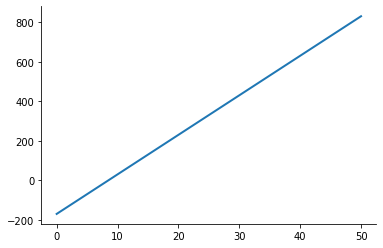

In [158]:
plt.plot(res_tech2[0]['v0'][0])
plt.show()

## Step 2:

post damage,

post 1st tech jump, and pre 2nd tech jump:


For each $\gamma_3$, $\alpha = 0.115$


$\vartheta = 0.0260$,  and $\lambda = 0.0798$, $\phi_m^{(1)}$

$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \phi^{(1)}(k, y) + \log(\alpha - i - \alpha \bar \vartheta \left[1 - \frac{e}{\alpha \bar\lambda \exp(k)}\right]^\theta) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell) \\
& + I_g (\phi^{(2)} - \phi^{(1)}(k, y))
\end{aligned}
$$

In [166]:
θ = 3
ϑ_bar = 0.0260
λ_bar = 0.0798
I_g = 1 / 60
i = 0
args = ((δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar, I_g),
        (γ1, γ2, γ3_list[i], y_bar), (θ_list, σy), (0.01, 5, 5))
res = solve_postdmg(y_grid, k_grid, args, False, res_tech2[i]['v0'],
                    res_tech2[i]['v0'], 0.5, 1e-6, 4_000)

Ep: 4000; PDE Err: 0.164150264005; ft Err: 0.000054202200; Iter: 1; CG Err:0.000000000094


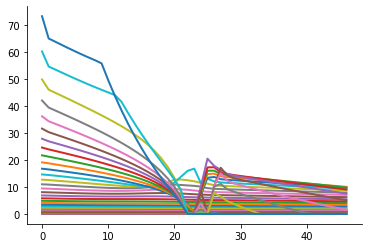

In [167]:
plt.plot(res['ems'])
plt.show()

In [172]:
θ = 3
ϑ_bar = 0.0260
λ_bar = 0.0798
I_g = 1 / 60
arg_list_tech1 = []
for i in range(len(γ3_list)):
    econ_param = (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar, I_g)
    dmg_param = (γ1, γ2, γ3_list[i], y_bar)
    climate_param = (θ_list, σy)
    uncertain_param = (0.01, 5, 5)
    v_tech2_i = res_tech2[i]['v0']
    args = (econ_param, dmg_param, climate_param, uncertain_param)
    args_func = (y_grid, k_grid, args, False, v_tech2_i, v_tech2_i, 0.3, 1e-6,
                 5_000)
    arg_list_tech1.append(args_func)

res_tech1 = solve_parallel(arg_list_tech1, solve_postdmg)

Ep: 5000; PDE Err: 0.033752403204; ft Err: 0.000018376182; Iter: 5; CG Err:0.000000000094
Ep: 5000; PDE Err: 0.021724893368; ft Err: 0.000011554552; Iter: 5; CG Err:0.000000000054
Ep: 5000; PDE Err: 0.020897863820; ft Err: 0.000008037718; Iter: 4; CG Err:0.000000000052
Ep: 5000; PDE Err: 0.026164925409; ft Err: 0.000013908889; Iter: 5; CG Err:0.000000000069
Ep: 5000; PDE Err: 0.049051418699; ft Err: 0.000036021726; Iter: 6; CG Err:0.000000000090
Ep: 5000; PDE Err: 0.020896941439; ft Err: 0.000009010716; Iter: 4; CG Err:0.000000000066
Ep: 5000; PDE Err: 0.020896453267; ft Err: 0.000009537858; Iter: 4; CG Err:0.000000000074
Ep: 5000; PDE Err: 0.020895469606; ft Err: 0.000010585650; Iter: 4; CG Err:0.000000000087
Ep: 5000; PDE Err: 0.082076634098; ft Err: 0.062081868859; Iter: 8; CG Err:0.000000000047
Ep: 5000; PDE Err: 0.020897318350; ft Err: 0.000008622884; Iter: 4; CG Err:0.000000000061


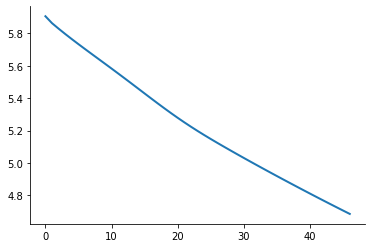

In [173]:
# plt.plot(res_tech1[0]['ems'][:, 33])
plt.plot(res_tech1[0]['ems'][:, 33])
plt.show()

## Step 3:

post damage,

pre 1st tech jump:

$\vartheta = 0.0453$ and $\lambda = 0.1206$, $\phi_m^{(0)}$

$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \phi(k, y) + \log(\alpha - i - \alpha \bar \vartheta \left[1 - \frac{e}{\alpha \bar\lambda \exp(k)}\right]^\theta) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell)
\end{aligned}
$$

In [189]:
θ = 3
ϑ_bar = 0.0453
λ_bar = 0.1206
I_g = 1 / 80
arg_list_tech0 = []
for i in range(len(γ3_list)):
    γ3_i = γ3_list[i]
    v_tech_i = res_tech1[i]['v0']
    econ_param = (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar, I_g)
    dmg_param = (γ1, γ2, γ3_i, y_bar)
    climate_param = (θ_list, σy)
    uncertain_param = (0.01, 5, 5)
    args = (econ_param, dmg_param, climate_param, uncertain_param)
    args_func = (y_grid, k_grid, args, False, v_tech_i, v_tech_i, 0.3, 1e-6,
                 5_000)
    arg_list_tech0.append(args_func)

res_tech0 = solve_parallel(arg_list_tech0, solve_postdmg)

Ep: 4794; PDE Err: 0.084818340038; ft Err: 0.000000998050; Iter: 1; CG Err:0.000000000048
Ep: 4794; PDE Err: 0.018245702632; ft Err: 0.000000997494; Iter: 1; CG Err:0.000000000048
Ep: 4794; PDE Err: 0.021400341820; ft Err: 0.000000997330; Iter: 1; CG Err:0.000000000048
Ep: 4793; PDE Err: 0.029375668853; ft Err: 0.000000997907; Iter: 1; CG Err:0.000000000047
Ep: 4794; PDE Err: 0.019846988179; ft Err: 0.000000997325; Iter: 1; CG Err:0.000000000048
Ep: 5000; PDE Err: 0.103633522462; ft Err: 0.000046553564; Iter: 1; CG Err:0.000000000032
Ep: 4794; PDE Err: 0.019077617990; ft Err: 0.000000997412; Iter: 1; CG Err:0.000000000048
Ep: 4793; PDE Err: 0.019449716439; ft Err: 0.000000999950; Iter: 1; CG Err:0.000000000048
Ep: 4793; PDE Err: 0.022670201714; ft Err: 0.000000999174; Iter: 1; CG Err:0.000000000047
Ep: 4794; PDE Err: 0.020622870856; ft Err: 0.000000997350; Iter: 1; CG Err:0.000000000048


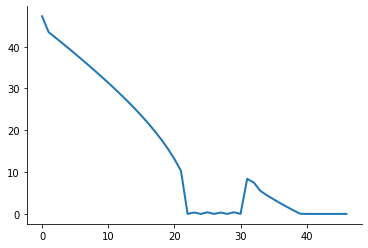

In [190]:
plt.plot(res_tech0[0]['ems'][:,-3])
plt.show()

## Step 4: Pre damage,  post 2nd tech jump


$\vartheta = 0$,  $\lambda = 0.0798$, $\Phi^{(2)}$

$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \Phi^{(2)}(k, y) + \log(\alpha - i - \alpha \bar \vartheta \left[1 - \frac{e}{\alpha \bar\lambda \exp(k)}\right]^\theta) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell)\\
& + \mathcal{I}(y) \sum \pi_d^m (\phi_m^{(2)}(y, \log k) - \phi(y, \log k)) \\
& + \xi_p \mathcal{I} \sum \pi_d (1 - g + g \log g)
\end{aligned}
$$


In [222]:
def solve_predmg(y_grid,
                 k_grid,
                 args,
                 post_tech=True,
                 v_tech=None,
                 v_pre=None,
                 v0=None,
                 ϵ=2,
                 tol=1e-6,
                 max_iter=2_000):

    (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar,
     I_g), (γ1, γ2, γ3_list, πd_o_list, y_bar), (θ_list, σy), (ξa, ξp, ξg) = args
    loc25 = np.abs(y_grid - 2.4).argmin()
    y_grid_cap = y_grid[:loc25 + 1]
    n_y = len(y_grid_cap)
    n_k = len(k_grid)
    dy = y_grid_cap[1] - y_grid_cap[0]
    dk = k_grid[1] - k_grid[0]

    (y_mat_cap, k_mat_cap) = np.meshgrid(y_grid_cap, k_grid, indexing='ij')
    stateSpace = np.hstack([
        y_mat_cap.reshape(-1, 1, order='F'),
        k_mat_cap.reshape(-1, 1, order='F')
    ])

    πa_o = np.ones((len(θ_list), n_y, n_k)) / len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y, n_k))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o

    πd_o = np.zeros((len(γ3_list), n_y, n_k))
    for i in range(len(γ3_list)):
        πd_o[i] = πd_o_list[i]

    dΛ = γ1 + γ2 * y_mat_cap
    ddΛ = γ2
    numy_bar = len(y_grid_cap) - 1
    v_tech_cap = v_tech[:, :loc25 + 1]
    if v_pre is not None:
        v_pre_cap = v_pre[:loc25 + 1]

    r1 = 1.5
    r2 = 2.5

    y_lower = 1.8
    I_y = r1 * (np.exp(r2 / 2 *
                       (y_mat_cap - y_lower)**2) - 1) * (y_mat_cap >= y_lower)
    # ϕ_m(ȳ):
    loc_bar = np.abs(y_grid_cap - y_bar).argmin()
    ϕ_ref = np.zeros((len(γ3_list), n_y, n_k))
    for i in range(len(γ3_list)):
        ϕ_ref[i] = v_tech[i, loc_bar]

    if v0 is None:
        ϕ = np.average(v_tech_cap, axis=0, weights=πd_o_list)
    else:
        ϕ = v0
    v_average = np.average(np.exp(-1 / ξp * v_tech),
                           weights=dmg_weight,
                           axis=0)
    ϕ_bound = -ξp * np.log(v_average)

    ϕ_dk = derivatives_2d(ϕ, 1, 1, dk)
    ems = 0 * np.ones(y_mat_cap.shape)
    print(ems.shape)
    print(ϕ_dk.shape)
    # initial i
    a_i = κ * ϕ_dk
    b_i = -(1 + α * κ) * ϕ_dk
    c_i = α * ϕ_dk - 1
    i = (-b_i - np.sqrt(b_i**2 - 4 * a_i * c_i)) / (2 * a_i)
    mc = 1 / (α - i - α * ϑ_bar * (1 - ems /
                                   (np.exp(k_mat_cap) * α * λ_bar))**θ)

    episode = 0
    lhs_error = 1

    vd = -1 / δ
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        ϕ_dy = derivatives_2d(ϕ, 0, 1, dy)
        ϕ_dyy = derivatives_2d(ϕ, 0, 2, dy)
        ϕ_dk = derivatives_2d(ϕ, 1, 1, dk)
        ϕ_dkk = derivatives_2d(ϕ, 1, 2, dk)
        # update control
        # updating controls
        i_new = (1 - mc / ϕ_dk) * (1 / κ)
        #     update emission
        if θ == 2 or ϑ_bar == 0:
            a = ϕ_dyy*σy**2 + vd*ddΛ*σy**2 - mc * \
                θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat_cap))
            b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat_cap)) + ϕ_dy*np.sum(θ_mat*πa, axis=0) \
                + vd*dΛ*np.sum(θ_mat*πa, axis=0)
            ems_new = -b / a
        elif θ == 3:
            a = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap)) / \
                (α**2*λ_bar**2*np.exp(2*k_mat_cap))
            b = - mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap))*2 / \
                (α*λ_bar*np.exp(k_mat_cap)) + (ϕ_dyy + vd*ddΛ)*σy**2
            c = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap)) + \
                (ϕ_dy + vd*dΛ)*np.sum(θ_mat*πa, axis=0)
            Δ = b**2 - 4 * a * c
            Δ[Δ < 0] = 0
            root1 = (-b - np.sqrt(Δ)) / (2 * a)
            root2 = (-b + np.sqrt(Δ)) / (2 * a)
            if root1.all() > 0:
                ems_new = root1
            else:
                ems_new = root2
        ems_new[ems_new < 0] = 0
        i_new = i_new * 0.05 + i * 0.95
        ems_new = ems_new * 0.05 + ems * 0.95
        ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat_cap))) * \
            ((1 - ems_new/(α*λ_bar*np.exp(k_mat_cap))) > 0)
        #     ratio[ratio > 1] = 1
        consumption = α - i_new - α * ϑ_bar * ratio**θ
        #     consumption[consumption < 1e-15] = 1e-15
        mc_new = 1 / consumption
        #     mc_new[mc_new <= 1e-15] = 1e-15
        #     mc_new = mc_new*0.05 + mc*0.95
        temp = ϕ_dy + vd * dΛ
        weight = np.array([-1 / ξa * temp * ems_new * θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o * np.exp(weight)
        πa[πa < 1e-15] = 1e-15
        πa = πa / np.sum(πa, axis=0)
        print("min ems:", np.min(ems_new))
        print("min mc", np.min(mc_new))
        # HJB coefficient

        g_dmg = np.exp(1 / ξp * (ϕ - ϕ_ref))
        entropy = np.sum(πa * (np.log(πa) - np.log(πa_o)), axis=0)
        #         A = -δ*np.ones(y_mat_cap.shape) - I_y*np.sum(g_dmg*πd_o, axis=0) - I_g*
        B_y = np.sum(θ_mat * πa, axis=0) * ems_new
        B_k = μk + i_new - 0.5 * κ * i_new**2 - 0.5 * σk**2
        C_yy = 0.5 * ems_new**2 * σy**2
        C_kk = 0.5 * σk**2 * np.ones(y_mat_cap.shape)
        if post_tech:
            A = -δ * np.ones(y_mat_cap.shape) - I_y * np.sum(g_dmg * πd_o,
                                                             axis=0)
            D = np.log(consumption) + k_mat_cap + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) + \
                ξa*entropy + I_y*np.sum(πd_o*(g_dmg*v_tech_cap), axis=0) + ξp * \
                I_y*np.sum(πd_o*(1 - g_dmg + g_dmg*np.log(g_dmg)), axis=0)
        else:
            g_tech = np.exp(1 / ξg * (ϕ - v_pre_cap))
            A = -δ*np.ones(y_mat_cap.shape) - I_y *\
                np.sum(g_dmg*πd_o, axis=0) - I_g*g_tech
            D = np.log(consumption) + k_mat_cap + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new \
                + 0.5*ddΛ*σy**2*ems_new**2) + ξa*entropy + I_y*np.sum(πd_o*(g_dmg*v_tech_cap), axis=0) \
                + ξp * I_y*np.sum(πd_o*(1 - g_dmg + g_dmg*np.log(g_dmg)), axis=0) + \
                I_g*g_tech*v_pre_cap + ξg*I_g * \
                (1 - g_tech + g_tech*np.log(g_tech))
        # PDE solver
        out = PDESolver_2d(stateSpace,
                           A,
                           B_y,
                           B_k,
                           C_yy,
                           C_kk,
                           D,
                           ϕ,
                           ϵ,
                           solverType='False Transient')
        out_comp = out[2].reshape(ϕ.shape, order="F")
        rhs = A * ϕ + B_y * ϕ_dy + B_k * ϕ_dk + C_yy * ϕ_dyy + C_kk * ϕ_dkk + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - ϕ) / ϵ))
        #     if episode % 1 == 0:

        episode += 1
        ϕ = out_comp
        ems = ems_new
        mc = mc_new
        i = i_new

        print(
            "Episode: {:d} pde err: {:.12f}; ft err: {:.12f}; Iterations: {:d}; cg err: {:.12f}"
            .format(episode, rhs_error, lhs_error, out[0], out[1]))
    solution = dict(
        v0=ϕ,
        ems=ems,
        inv=i,
        g_dmg=g_dmg,
        πa=πa,
        v_bound=ϕ_bound,
    )
    return solution

In [206]:
θ = 3
ϑ_bar = 0
λ_bar = 0.0798
I_g = 0
πd_o_list = np.ones(len(γ3_list))/len(γ3_list)
econ_param = (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar, I_g)
dmg_param = (γ1, γ2, γ3_list, πd_o_list, y_bar)
climate_param = (θ_list, σy)
uncertain_param = (0.01, 5, 5)
v_tech = np.zeros((len(res_tech2), n_y, n_k))
args = (econ_param, dmg_param, climate_param, uncertain_param)
for i in range(len(res_tech2)):
    v_tech[i] = res_tech2[i]['v0']
res_tech2_prd = solve_predmg(y_grid, k_grid, args,
                             True, v_tech, None, None, 2, 1e-5, 2_000)

(25, 51)
(25, 51)
min ems: 0.0
min mc 39.99788232983293
Episode: 1 pde err: 0.000000974765; ft err: 0.000000956696; Iterations: 2; cg err: 0.000000000038


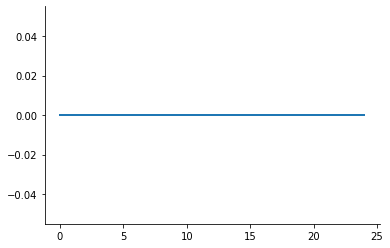

In [207]:
plt.plot(res_tech2_prd['ems'])
plt.show()

## Step 5: Pre damage,  post 1st tech jump, pre 2nd tech jump

$\vartheta = 0.0260$,  $\lambda = 0.0798$, $\Phi^{(1)}$


$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \Phi^{(1)}(k, y) + \log(\alpha - i - \alpha \bar \vartheta \left[1 - \frac{e}{\alpha \bar\lambda \exp(k)}\right]^\theta) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell)\\
& + \mathcal{I}(y) \sum g \pi_d^m  (\phi_m^{(1)}(y, \log k) - \Phi^{(1)}(y, \log k)) \\
& + \xi_p \mathcal{I}(y) \sum \pi_d^m (1 - g + g \log g)\\
& + \mathcal{I}_g \sum (\Phi^{(2)}(y, \log k) - \Phi^{(1)}(y, \log k)) \\
& + \xi_p \mathcal{I}_g \sum \pi_d (1 - g + g \log g)
\end{aligned}
$$


In [208]:
ϑ_bar = 0.0260
λ_bar = 0.0798
I_g = 1/60
πd_o_list = np.ones(len(γ3_list))/len(γ3_list)
econ_param = (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar, I_g)
dmg_param = (γ1, γ2, γ3_list, πd_o_list, y_bar)
climate_param = (θ_list, σy)
uncertain_param = (0.01, 5, 5)
v_tech = np.zeros((len(res_tech1), n_y, n_k))
args = (econ_param, dmg_param, climate_param, uncertain_param)
for i in range(len(res_tech1)):
    v_tech[i] = res_tech1[i]['v0']
v_pre = res_tech2_prd['v0']
res_tech1_prd = solve_predmg(y_grid, k_grid, args,
                             False, v_tech, v_pre, v_pre, 0.3, 1e-6, 2_000)

(25, 51)
(25, 51)
min ems: 0.0004557712769114271
min mc 43.77344731053152
Episode: 1 pde err: 10.646726326068; ft err: 5.670761365607; Iterations: 5; cg err: 0.000000000010
min ems: 0.0008887045155711018
min mc 42.602076477618255
Episode: 2 pde err: 6.367338751848; ft err: 3.905302491691; Iterations: 5; cg err: 0.000000000033
min ems: 0.001299976219581462
min mc 41.75696653025823
Episode: 3 pde err: 4.150788055742; ft err: 2.763243046661; Iterations: 6; cg err: 0.000000000018
min ems: 0.0016906899172373562
min mc 41.14034375730721
Episode: 4 pde err: 2.865096469980; ft err: 2.005791798127; Iterations: 6; cg err: 0.000000000068
min ems: 0.0020618842579592984
min mc 40.68855974603931
Episode: 5 pde err: 2.054388592324; ft err: 1.514012735971; Iterations: 7; cg err: 0.000000000047
min ems: 0.0024145393828216657
min mc 40.35816038159683
Episode: 6 pde err: 1.550919711896; ft err: 1.215602081970; Iterations: 8; cg err: 0.000000000022
min ems: 0.002749582111198689
min mc 40.11838476014816
Ep

min ems: 0.0021642649553241713
min mc 39.550281836676064
Episode: 57 pde err: 0.100858584095; ft err: 0.100954745560; Iterations: 12; cg err: 0.000000000043
min ems: 0.0020560517075579625
min mc 39.550854318965506
Episode: 58 pde err: 0.099406234293; ft err: 0.099745403940; Iterations: 12; cg err: 0.000000000040
min ems: 0.001953249122180064
min mc 39.551371885601384
Episode: 59 pde err: 0.097985086154; ft err: 0.098560701084; Iterations: 12; cg err: 0.000000000037
min ems: 0.0018555866660710607
min mc 39.55183961205693
Episode: 60 pde err: 0.096594107063; ft err: 0.097400251497; Iterations: 12; cg err: 0.000000000034
min ems: 0.0017628073327675077
min mc 39.55226214901025
Episode: 61 pde err: 0.095232311281; ft err: 0.096263720825; Iterations: 11; cg err: 0.000000000094
min ems: 0.0016746669661291322
min mc 39.55264374904107
Episode: 62 pde err: 0.093898757311; ft err: 0.095150202997; Iterations: 11; cg err: 0.000000000088
min ems: 0.0015909336178226755
min mc 39.55298829349861
Episod

Episode: 116 pde err: 0.087616843718; ft err: 0.057813461410; Iterations: 10; cg err: 0.000000000076
min ems: 9.970725144628912e-05
min mc 39.55620097677783
Episode: 117 pde err: 0.088006196422; ft err: 0.057362058391; Iterations: 10; cg err: 0.000000000077
min ems: 9.472188887397466e-05
min mc 39.55620290638226
Episode: 118 pde err: 0.088383426237; ft err: 0.056913654347; Iterations: 10; cg err: 0.000000000077
min ems: 8.998579443027592e-05
min mc 39.55620469191008
Episode: 119 pde err: 0.088749343308; ft err: 0.056497127238; Iterations: 10; cg err: 0.000000000078
min ems: 8.548650470876212e-05
min mc 39.55620634532664
Episode: 120 pde err: 0.089104705104; ft err: 0.056111797873; Iterations: 10; cg err: 0.000000000079
min ems: 8.1212179473324e-05
min mc 39.55620787751843
Episode: 121 pde err: 0.089450208378; ft err: 0.055728681252; Iterations: 10; cg err: 0.000000000079
min ems: 7.71515704996578e-05
min mc 39.5562092983958
Episode: 122 pde err: 0.089786485670; ft err: 0.055347742014; 

Episode: 174 pde err: 0.155642718340; ft err: 0.039394008417; Iterations: 11; cg err: 0.000000000056
min ems: 5.089742971381735e-06
min mc 39.556228960250536
Episode: 175 pde err: 0.156448854086; ft err: 0.039159153707; Iterations: 11; cg err: 0.000000000066
min ems: 4.835255822812648e-06
min mc 39.556229010781905
Episode: 176 pde err: 0.157243105928; ft err: 0.038926509791; Iterations: 11; cg err: 0.000000000077
min ems: 4.5934930316720156e-06
min mc 39.55622905863996
Episode: 177 pde err: 0.158025686184; ft err: 0.038698631239; Iterations: 11; cg err: 0.000000000088
min ems: 4.363818380088415e-06
min mc 39.55622910397086
Episode: 178 pde err: 0.158796835353; ft err: 0.038471970141; Iterations: 12; cg err: 0.000000000036
min ems: 4.145627461083994e-06
min mc 39.55622914691234
Episode: 179 pde err: 0.159556814970; ft err: 0.038246606749; Iterations: 12; cg err: 0.000000000041
min ems: 3.938346088029794e-06
min mc 39.55622918759411
Episode: 180 pde err: 0.160305897989; ft err: 0.0380224

Episode: 233 pde err: 0.189666454095; ft err: 0.028003754336; Iterations: 14; cg err: 0.000000000042
min ems: 2.4682466903874533e-07
min mc 39.55622988908454
Episode: 234 pde err: 0.190079875620; ft err: 0.027839153188; Iterations: 14; cg err: 0.000000000040
min ems: 2.3448343558680805e-07
min mc 39.556229891302834
Episode: 235 pde err: 0.190489148651; ft err: 0.027674949832; Iterations: 13; cg err: 0.000000000096
min ems: 2.2275926380746763e-07
min mc 39.55622989340761
Episode: 236 pde err: 0.190894303430; ft err: 0.027510866063; Iterations: 13; cg err: 0.000000000091
min ems: 2.1162130061709425e-07
min mc 39.556229895404684
Episode: 237 pde err: 0.191295384578; ft err: 0.027347013067; Iterations: 13; cg err: 0.000000000087
min ems: 2.0104023558623953e-07
min mc 39.55622989729955
Episode: 238 pde err: 0.191692427041; ft err: 0.027185583630; Iterations: 13; cg err: 0.000000000083
min ems: 1.9098822380692756e-07
min mc 39.55622989909744
Episode: 239 pde err: 0.192085465687; ft err: 0.02

Episode: 293 pde err: 0.208266865572; ft err: 0.019462364354; Iterations: 12; cg err: 0.000000000048
min ems: 1.1371162887635946e-08
min mc 39.55622993053534
Episode: 294 pde err: 0.208488653715; ft err: 0.019337277337; Iterations: 12; cg err: 0.000000000048
min ems: 1.0802604743254148e-08
min mc 39.5562299306289
Episode: 295 pde err: 0.208708126703; ft err: 0.019213726454; Iterations: 12; cg err: 0.000000000047
min ems: 1.0262474506091441e-08
min mc 39.556229930717606
Episode: 296 pde err: 0.208925309203; ft err: 0.019092760101; Iterations: 12; cg err: 0.000000000047
min ems: 9.749350780786869e-09
min mc 39.55622993080168
Episode: 297 pde err: 0.209140225653; ft err: 0.018971684350; Iterations: 12; cg err: 0.000000000047
min ems: 9.261883241747524e-09
min mc 39.55622993088134
Episode: 298 pde err: 0.209352900262; ft err: 0.018850479821; Iterations: 12; cg err: 0.000000000046
min ems: 8.798789079660147e-09
min mc 39.55622993095684
Episode: 299 pde err: 0.209563357010; ft err: 0.0187291

Episode: 353 pde err: 0.218213958450; ft err: 0.013050461792; Iterations: 11; cg err: 0.000000000080
min ems: 5.238671884812759e-10
min mc 39.55622993223953
Episode: 354 pde err: 0.218333153671; ft err: 0.012961130684; Iterations: 11; cg err: 0.000000000079
min ems: 4.976738290572121e-10
min mc 39.55622993224277
Episode: 355 pde err: 0.218451145717; ft err: 0.012871558151; Iterations: 11; cg err: 0.000000000078
min ems: 4.727901376043514e-10
min mc 39.556229932245856
Episode: 356 pde err: 0.218567947634; ft err: 0.012781734712; Iterations: 11; cg err: 0.000000000078
min ems: 4.491506307241338e-10
min mc 39.556229932248776
Episode: 357 pde err: 0.218683572319; ft err: 0.012691651048; Iterations: 11; cg err: 0.000000000077
min ems: 4.266930991879271e-10
min mc 39.556229932251455
Episode: 358 pde err: 0.218798032522; ft err: 0.012601298028; Iterations: 11; cg err: 0.000000000076
min ems: 4.0535844422853076e-10
min mc 39.55622993225396
Episode: 359 pde err: 0.218911340849; ft err: 0.012513

Episode: 413 pde err: 0.223618263903; ft err: 0.008303798414; Iterations: 11; cg err: 0.000000000046
min ems: 2.4134456069192045e-11
min mc 39.556229932284474
Episode: 414 pde err: 0.223683995465; ft err: 0.008231789705; Iterations: 11; cg err: 0.000000000045
min ems: 2.2927733265732442e-11
min mc 39.55622993228443
Episode: 415 pde err: 0.223749092718; ft err: 0.008159592356; Iterations: 11; cg err: 0.000000000045
min ems: 2.1781346602445818e-11
min mc 39.55622993228433
Episode: 416 pde err: 0.223813562220; ft err: 0.008092473303; Iterations: 11; cg err: 0.000000000045
min ems: 2.0692279272323525e-11
min mc 39.556229932284204
Episode: 417 pde err: 0.223877410455; ft err: 0.008032175136; Iterations: 11; cg err: 0.000000000044
min ems: 1.965766530870735e-11
min mc 39.55622993228405
Episode: 418 pde err: 0.223940643834; ft err: 0.007971720875; Iterations: 11; cg err: 0.000000000044
min ems: 1.867478204327198e-11
min mc 39.55622993228384
Episode: 419 pde err: 0.224003268695; ft err: 0.0079

min mc 39.55622993227816
Episode: 473 pde err: 0.226632086087; ft err: 0.005010726791; Iterations: 10; cg err: 0.000000000058
min ems: 1.1118695397670998e-12
min mc 39.55622993227804
Episode: 474 pde err: 0.226669223274; ft err: 0.004965557166; Iterations: 10; cg err: 0.000000000058
min ems: 1.0562760627787449e-12
min mc 39.556229932277965
Episode: 475 pde err: 0.226706015055; ft err: 0.004920362237; Iterations: 10; cg err: 0.000000000057
min ems: 1.0034622596398077e-12
min mc 39.55622993227788
Episode: 476 pde err: 0.226742464826; ft err: 0.004875146476; Iterations: 10; cg err: 0.000000000056
min ems: 9.532891466578173e-13
min mc 39.556229932277816
Episode: 477 pde err: 0.226778575949; ft err: 0.004829914457; Iterations: 10; cg err: 0.000000000056
min ems: 9.056246893249264e-13
min mc 39.556229932277745
Episode: 478 pde err: 0.226814351748; ft err: 0.004784670860; Iterations: 10; cg err: 0.000000000055
min ems: 8.603434548586801e-13
min mc 39.55622993227768
Episode: 479 pde err: 0.226

Episode: 532 pde err: 0.228328122677; ft err: 0.002974205365; Iterations: 9; cg err: 0.000000000097
min ems: 5.3919585470300095e-14
min mc 39.5562299322762
Episode: 533 pde err: 0.228349689794; ft err: 0.002949438032; Iterations: 9; cg err: 0.000000000096
min ems: 5.1223606196785085e-14
min mc 39.55622993227621
Episode: 534 pde err: 0.228371063061; ft err: 0.002924669831; Iterations: 9; cg err: 0.000000000095
min ems: 4.866242588694583e-14
min mc 39.556229932276224
Episode: 535 pde err: 0.228392243840; ft err: 0.002899903297; Iterations: 9; cg err: 0.000000000094
min ems: 4.6229304592598536e-14
min mc 39.55622993227618
Episode: 536 pde err: 0.228413233627; ft err: 0.002875140973; Iterations: 9; cg err: 0.000000000093
min ems: 4.3917839362968605e-14
min mc 39.55622993227618
Episode: 537 pde err: 0.228434034003; ft err: 0.002850385418; Iterations: 9; cg err: 0.000000000092
min ems: 4.172194739482017e-14
min mc 39.556229932276196
Episode: 538 pde err: 0.228454646609; ft err: 0.00282563919

Episode: 592 pde err: 0.229332030526; ft err: 0.001746739934; Iterations: 9; cg err: 0.000000000055
min ems: 2.484064464076501e-15
min mc 39.556229932275755
Episode: 593 pde err: 0.229344613144; ft err: 0.001731218629; Iterations: 9; cg err: 0.000000000055
min ems: 2.359861240872676e-15
min mc 39.55622993227575
Episode: 594 pde err: 0.229357084536; ft err: 0.001715722760; Iterations: 9; cg err: 0.000000000054
min ems: 2.2418681788290423e-15
min mc 39.55622993227573
Episode: 595 pde err: 0.229369445725; ft err: 0.001700253891; Iterations: 9; cg err: 0.000000000054
min ems: 2.12977476988759e-15
min mc 39.55622993227572
Episode: 596 pde err: 0.229381697723; ft err: 0.001684813574; Iterations: 9; cg err: 0.000000000053
min ems: 2.0232860313932105e-15
min mc 39.5562299322757
Episode: 597 pde err: 0.229393841533; ft err: 0.001669403354; Iterations: 9; cg err: 0.000000000053
min ems: 1.92212172982355e-15
min mc 39.55622993227567
Episode: 598 pde err: 0.229405878148; ft err: 0.001654024767; It

Episode: 651 pde err: 0.229913375088; ft err: 0.001032920774; Iterations: 8; cg err: 0.000000000070
min ems: 1.2046352687435256e-16
min mc 39.556229932275734
Episode: 652 pde err: 0.229920861793; ft err: 0.001023589093; Iterations: 8; cg err: 0.000000000069
min ems: 1.1444035053063493e-16
min mc 39.55622993227573
Episode: 653 pde err: 0.229928283433; ft err: 0.001014282206; Iterations: 8; cg err: 0.000000000068
min ems: 1.0871833300410318e-16
min mc 39.55622993227572
Episode: 654 pde err: 0.229935640596; ft err: 0.001005000935; Iterations: 8; cg err: 0.000000000068
min ems: 1.0328241635389802e-16
min mc 39.5562299322757
Episode: 655 pde err: 0.229942933862; ft err: 0.000995746090; Iterations: 8; cg err: 0.000000000067
min ems: 9.811829553620311e-17
min mc 39.55622993227565
Episode: 656 pde err: 0.229950163810; ft err: 0.000986518476; Iterations: 8; cg err: 0.000000000067
min ems: 9.321238075939295e-17
min mc 39.55622993227563
Episode: 657 pde err: 0.229957331010; ft err: 0.000977318885

Episode: 711 pde err: 0.230265078511; ft err: 0.000607049422; Iterations: 8; cg err: 0.000000000042
min ems: 5.549730468360711e-18
min mc 39.55622993227573
Episode: 712 pde err: 0.230269534876; ft err: 0.000601568052; Iterations: 8; cg err: 0.000000000041
min ems: 5.2722439449426746e-18
min mc 39.556229932275706
Episode: 713 pde err: 0.230273953220; ft err: 0.000596104946; Iterations: 8; cg err: 0.000000000041
min ems: 5.008631747695541e-18
min mc 39.55622993227568
Episode: 714 pde err: 0.230278333881; ft err: 0.000590660511; Iterations: 8; cg err: 0.000000000041
min ems: 4.758200160310764e-18
min mc 39.55622993227566
Episode: 715 pde err: 0.230282677188; ft err: 0.000585235148; Iterations: 8; cg err: 0.000000000040
min ems: 4.520290152295225e-18
min mc 39.55622993227564
Episode: 716 pde err: 0.230286983471; ft err: 0.000579731783; Iterations: 7; cg err: 0.000000000100
min ems: 4.294275644680464e-18
min mc 39.55622993227564
Episode: 717 pde err: 0.230291246667; ft err: 0.000574350736; 

Episode: 771 pde err: 0.230475217343; ft err: 0.000358185799; Iterations: 7; cg err: 0.000000000059
min ems: 2.556749671091405e-19
min mc 39.556229932275734
Episode: 772 pde err: 0.230477893686; ft err: 0.000354997426; Iterations: 7; cg err: 0.000000000059
min ems: 2.4289121875368346e-19
min mc 39.55622993227576
Episode: 773 pde err: 0.230480547566; ft err: 0.000351820877; Iterations: 7; cg err: 0.000000000058
min ems: 2.307466578159993e-19
min mc 39.55622993227576
Episode: 774 pde err: 0.230483179178; ft err: 0.000348656353; Iterations: 7; cg err: 0.000000000058
min ems: 2.1920932492519933e-19
min mc 39.55622993227572
Episode: 775 pde err: 0.230485788712; ft err: 0.000345504050; Iterations: 7; cg err: 0.000000000057
min ems: 2.0824885867893934e-19
min mc 39.55622993227572
Episode: 776 pde err: 0.230488376358; ft err: 0.000342364163; Iterations: 7; cg err: 0.000000000057
min ems: 1.9783641574499237e-19
min mc 39.55622993227572
Episode: 777 pde err: 0.230490942303; ft err: 0.00033923688

min ems: 1.2398836148119637e-20
min mc 39.55622993227558
Episode: 831 pde err: 0.230601813374; ft err: 0.000212139245; Iterations: 6; cg err: 0.000000000090
min ems: 1.1778894340713655e-20
min mc 39.556229932275606
Episode: 832 pde err: 0.230603431627; ft err: 0.000210288687; Iterations: 6; cg err: 0.000000000090
min ems: 1.1189949623677972e-20
min mc 39.556229932275606
Episode: 833 pde err: 0.230605036679; ft err: 0.000208445380; Iterations: 6; cg err: 0.000000000089
min ems: 1.0630452142494073e-20
min mc 39.55622993227561
Episode: 834 pde err: 0.230606628633; ft err: 0.000206609423; Iterations: 6; cg err: 0.000000000088
min ems: 1.0098929535369369e-20
min mc 39.55622993227558
Episode: 835 pde err: 0.230608207597; ft err: 0.000204780916; Iterations: 6; cg err: 0.000000000087
min ems: 9.5939830586009e-21
min mc 39.55622993227558
Episode: 836 pde err: 0.230609773683; ft err: 0.000202959954; Iterations: 6; cg err: 0.000000000087
min ems: 9.114283905670855e-21
min mc 39.556229932275585
Ep

Episode: 891 pde err: 0.230678897668; ft err: 0.000126022263; Iterations: 6; cg err: 0.000000000056
min ems: 5.426512945652239e-22
min mc 39.556229932275535
Episode: 892 pde err: 0.230679889293; ft err: 0.000124947907; Iterations: 6; cg err: 0.000000000055
min ems: 5.155187298369627e-22
min mc 39.556229932275556
Episode: 893 pde err: 0.230680872841; ft err: 0.000123877875; Iterations: 6; cg err: 0.000000000055
min ems: 4.897427933451146e-22
min mc 39.556229932275585
Episode: 894 pde err: 0.230681848376; ft err: 0.000122812218; Iterations: 6; cg err: 0.000000000054
min ems: 4.652556536778589e-22
min mc 39.55622993227557
Episode: 895 pde err: 0.230682815964; ft err: 0.000121750985; Iterations: 6; cg err: 0.000000000054
min ems: 4.419928709939659e-22
min mc 39.55622993227559
Episode: 896 pde err: 0.230683775668; ft err: 0.000120753905; Iterations: 5; cg err: 0.000000000099
min ems: 4.1989322744426753e-22
min mc 39.55622993227559
Episode: 897 pde err: 0.230684744867; ft err: 0.000119699243

Episode: 951 pde err: 0.230726423127; ft err: 0.000075049163; Iterations: 5; cg err: 0.000000000065
min ems: 2.4999836060629096e-23
min mc 39.556229932275734
Episode: 952 pde err: 0.230727037234; ft err: 0.000074423712; Iterations: 5; cg err: 0.000000000064
min ems: 2.3749844257597641e-23
min mc 39.556229932275734
Episode: 953 pde err: 0.230727646410; ft err: 0.000073800814; Iterations: 5; cg err: 0.000000000064
min ems: 2.2562352044717757e-23
min mc 39.556229932275706
Episode: 954 pde err: 0.230728250694; ft err: 0.000073180493; Iterations: 5; cg err: 0.000000000063
min ems: 2.1434234442481868e-23
min mc 39.55622993227568
Episode: 955 pde err: 0.230728850123; ft err: 0.000072562777; Iterations: 5; cg err: 0.000000000063
min ems: 2.0362522720357774e-23
min mc 39.5562299322757
Episode: 956 pde err: 0.230729444735; ft err: 0.000071947690; Iterations: 5; cg err: 0.000000000062
min ems: 1.9344396584339884e-23
min mc 39.55622993227565
Episode: 957 pde err: 0.230730034567; ft err: 0.00007133

Episode: 1009 pde err: 0.230754951862; ft err: 0.000045495136; Iterations: 5; cg err: 0.000000000040
min ems: 1.2761633484985427e-24
min mc 39.55622993227546
Episode: 1010 pde err: 0.230755334855; ft err: 0.000045127899; Iterations: 5; cg err: 0.000000000040
min ems: 1.2123551810736155e-24
min mc 39.556229932275464
Episode: 1011 pde err: 0.230755714711; ft err: 0.000044762125; Iterations: 5; cg err: 0.000000000040
min ems: 1.1517374220199346e-24
min mc 39.556229932275464
Episode: 1012 pde err: 0.230756091455; ft err: 0.000044397829; Iterations: 5; cg err: 0.000000000039
min ems: 1.0941505509189377e-24
min mc 39.55622993227546
Episode: 1013 pde err: 0.230756465110; ft err: 0.000044035025; Iterations: 5; cg err: 0.000000000039
min ems: 1.0394430233729908e-24
min mc 39.556229932275485
Episode: 1014 pde err: 0.230756835701; ft err: 0.000043673725; Iterations: 5; cg err: 0.000000000039
min ems: 9.874708722043413e-25
min mc 39.55622993227549
Episode: 1015 pde err: 0.230757203252; ft err: 0.0

min ems: 6.188693572615092e-26
min mc 39.55622993227555
Episode: 1069 pde err: 0.230773250956; ft err: 0.000027255680; Iterations: 4; cg err: 0.000000000063
min ems: 5.879258893984336e-26
min mc 39.55622993227553
Episode: 1070 pde err: 0.230773483670; ft err: 0.000027012252; Iterations: 4; cg err: 0.000000000063
min ems: 5.585295949285119e-26
min mc 39.556229932275485
Episode: 1071 pde err: 0.230773714400; ft err: 0.000026770163; Iterations: 4; cg err: 0.000000000062
min ems: 5.306031151820863e-26
min mc 39.55622993227544
Episode: 1072 pde err: 0.230773943163; ft err: 0.000026529416; Iterations: 4; cg err: 0.000000000062
min ems: 5.0407295942298196e-26
min mc 39.55622993227543
Episode: 1073 pde err: 0.230774169977; ft err: 0.000026316059; Iterations: 4; cg err: 0.000000000061
min ems: 4.7886931145183285e-26
min mc 39.55622993227545
Episode: 1074 pde err: 0.230774394857; ft err: 0.000026105030; Iterations: 4; cg err: 0.000000000061
min ems: 4.5492584587924116e-26
min mc 39.5562299322755

min ems: 3.001177567181248e-27
min mc 39.556229932275585
Episode: 1128 pde err: 0.230784156909; ft err: 0.000016525825; Iterations: 3; cg err: 0.000000000072
min ems: 2.8511186888221855e-27
min mc 39.556229932275585
Episode: 1129 pde err: 0.230784298166; ft err: 0.000016382499; Iterations: 3; cg err: 0.000000000078
min ems: 2.708562754381076e-27
min mc 39.55622993227557
Episode: 1130 pde err: 0.230784435358; ft err: 0.000016240604; Iterations: 3; cg err: 0.000000000071
min ems: 2.5731346166620222e-27
min mc 39.55622993227555
Episode: 1131 pde err: 0.230784573985; ft err: 0.000016098877; Iterations: 3; cg err: 0.000000000076
min ems: 2.444477885828921e-27
min mc 39.55622993227555
Episode: 1132 pde err: 0.230784708641; ft err: 0.000015958449; Iterations: 3; cg err: 0.000000000070
min ems: 2.322253991537475e-27
min mc 39.55622993227555
Episode: 1133 pde err: 0.230784844693; ft err: 0.000015818326; Iterations: 3; cg err: 0.000000000075
min ems: 2.206141291960601e-27
min mc 39.5562299322755

Episode: 1188 pde err: 0.230790610944; ft err: 0.000009951601; Iterations: 3; cg err: 0.000000000045
min ems: 1.3135046488198006e-28
min mc 39.55622993227597
Episode: 1189 pde err: 0.230790695141; ft err: 0.000009866158; Iterations: 3; cg err: 0.000000000042
min ems: 1.2478294163788106e-28
min mc 39.55622993227597
Episode: 1190 pde err: 0.230790778963; ft err: 0.000009803055; Iterations: 2; cg err: 0.000000000095
min ems: 1.18543794555987e-28
min mc 39.55622993227597
Episode: 1191 pde err: 0.230790850175; ft err: 0.000009701047; Iterations: 3; cg err: 0.000000000044
min ems: 1.1261660482818764e-28
min mc 39.556229932276004
Episode: 1192 pde err: 0.230790932278; ft err: 0.000009616901; Iterations: 3; cg err: 0.000000000041
min ems: 1.0698577458677824e-28
min mc 39.556229932276
Episode: 1193 pde err: 0.230791013969; ft err: 0.000009555096; Iterations: 2; cg err: 0.000000000093
min ems: 1.0163648585743932e-28
min mc 39.556229932276
Episode: 1194 pde err: 0.230791083294; ft err: 0.00000945

min ems: 6.051289513955512e-30
min mc 39.556229932275734
Episode: 1249 pde err: 0.230794401222; ft err: 0.000005943882; Iterations: 3; cg err: 0.000000000028
min ems: 5.748725038257736e-30
min mc 39.55622993227573
Episode: 1250 pde err: 0.230794451043; ft err: 0.000005923816; Iterations: 2; cg err: 0.000000000087
min ems: 5.461288786344849e-30
min mc 39.55622993227577
Episode: 1251 pde err: 0.230794493436; ft err: 0.000005845609; Iterations: 3; cg err: 0.000000000028
min ems: 5.188224347027607e-30
min mc 39.55622993227577
Episode: 1252 pde err: 0.230794542413; ft err: 0.000005825745; Iterations: 2; cg err: 0.000000000086
min ems: 4.928813129676226e-30
min mc 39.55622993227579
Episode: 1253 pde err: 0.230794584089; ft err: 0.000005748361; Iterations: 3; cg err: 0.000000000027
min ems: 4.682372473192415e-30
min mc 39.5562299322758
Episode: 1254 pde err: 0.230794632240; ft err: 0.000005728704; Iterations: 2; cg err: 0.000000000085
min ems: 4.448253849532794e-30
min mc 39.5562299322758
Epi

Episode: 1309 pde err: 0.230796350035; ft err: 0.000003622959; Iterations: 2; cg err: 0.000000000085
min ems: 2.6484260694379148e-31
min mc 39.55622993227548
Episode: 1310 pde err: 0.230796371501; ft err: 0.000003593526; Iterations: 2; cg err: 0.000000000084
min ems: 2.5160047659660187e-31
min mc 39.556229932275514
Episode: 1311 pde err: 0.230796392793; ft err: 0.000003564240; Iterations: 2; cg err: 0.000000000084
min ems: 2.3902045276677177e-31
min mc 39.556229932275535
Episode: 1312 pde err: 0.230796413912; ft err: 0.000003535102; Iterations: 2; cg err: 0.000000000083
min ems: 2.270694301284332e-31
min mc 39.556229932275585
Episode: 1313 pde err: 0.230796434859; ft err: 0.000003506111; Iterations: 2; cg err: 0.000000000083
min ems: 2.157159586220115e-31
min mc 39.55622993227562
Episode: 1314 pde err: 0.230796455637; ft err: 0.000003477269; Iterations: 2; cg err: 0.000000000082
min ems: 2.0493016069091095e-31
min mc 39.55622993227563
Episode: 1315 pde err: 0.230796476248; ft err: 0.00

Episode: 1370 pde err: 0.230797207694; ft err: 0.000002174655; Iterations: 1; cg err: 0.000000000061
min ems: 1.1591183381826756e-32
min mc 39.55622993227582
Episode: 1371 pde err: 0.230797217457; ft err: 0.000002157529; Iterations: 1; cg err: 0.000000000061
min ems: 1.1011624212735418e-32
min mc 39.55622993227584
Episode: 1372 pde err: 0.230797227163; ft err: 0.000002140487; Iterations: 1; cg err: 0.000000000061
min ems: 1.0461043002098647e-32
min mc 39.55622993227583
Episode: 1373 pde err: 0.230797236811; ft err: 0.000002123528; Iterations: 1; cg err: 0.000000000060
min ems: 9.937990851993714e-33
min mc 39.556229932275855
Episode: 1374 pde err: 0.230797246403; ft err: 0.000002106654; Iterations: 1; cg err: 0.000000000060
min ems: 9.441091309394028e-33
min mc 39.556229932275855
Episode: 1375 pde err: 0.230797255938; ft err: 0.000002089865; Iterations: 1; cg err: 0.000000000060
min ems: 8.969036743924326e-33
min mc 39.556229932275876
Episode: 1376 pde err: 0.230797265418; ft err: 0.000

Episode: 1431 pde err: 0.230797718434; ft err: 0.000001318334; Iterations: 1; cg err: 0.000000000046
min ems: 5.073033140005738e-34
min mc 39.55622993227555
Episode: 1432 pde err: 0.230797725684; ft err: 0.000001307168; Iterations: 1; cg err: 0.000000000046
min ems: 4.819381483005451e-34
min mc 39.55622993227557
Episode: 1433 pde err: 0.230797732906; ft err: 0.000001296515; Iterations: 1; cg err: 0.000000000046
min ems: 4.578412408855178e-34
min mc 39.55622993227559
Episode: 1434 pde err: 0.230797740101; ft err: 0.000001286505; Iterations: 1; cg err: 0.000000000046
min ems: 4.349491788412419e-34
min mc 39.55622993227561
Episode: 1435 pde err: 0.230797747269; ft err: 0.000001276544; Iterations: 1; cg err: 0.000000000045
min ems: 4.132017198991798e-34
min mc 39.556229932275635
Episode: 1436 pde err: 0.230797754410; ft err: 0.000001266634; Iterations: 1; cg err: 0.000000000045
min ems: 3.9254163390422075e-34
min mc 39.55622993227564
Episode: 1437 pde err: 0.230797761524; ft err: 0.0000012

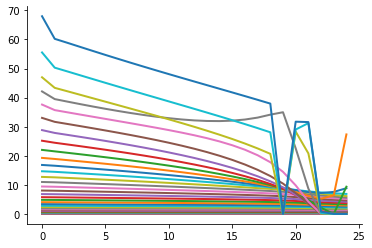

In [209]:
plt.plot(res_tech1_prd['ems'])
plt.show()

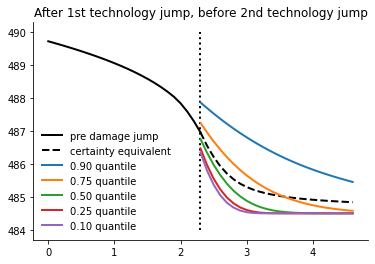

In [210]:
loc_k0 = np.abs(np.exp(k_grid) - k0).argmin()
loc_bar = np.abs(y_grid - y_bar).argmin()
v = res_tech1_prd['v0']
v_bound = res_tech1_prd['v_bound']
plt.plot(y_grid[:loc_bar+1], v[:loc_bar+1, loc_k0],
         color='black', label="pre damage jump")
plt.plot(y_grid[loc_bar:], v_bound[loc_bar:, loc_k0],
         color='black', linestyle='dashed', label='certainty equivalent')
quantile_list = [0.1, 0.25, 0.5, 0.75, 0.9]
v_tech = np.zeros((len(res_tech1), n_y, n_k))
for i in range(len(res_tech1)):
    v_tech[i] = res_tech1[i]['v0']
for i in range(len(quantile_list)):
    plt.plot(y_grid[loc_bar:], np.quantile(v_tech[:, loc_bar:, loc_k0], quantile_list[4-i], axis=0),
             label="{:.2f} quantile".format(quantile_list[4-i]))

plt.vlines(y_bar, 484, 490, color='black', linestyle=':')
plt.title('After 1st technology jump, before 2nd technology jump')
plt.legend()
# plt.savefig('Phi_1.png', dpi=300)

## Step 6: Pre damage,  pre 1nd tech jump

$\vartheta = 0.0453$,  $\lambda = 0.1206$, $\Phi^{(0)}$


$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \Phi^{(0)}(k, y) + \log(\alpha - i - \alpha \bar \vartheta \left[1 - \frac{e}{\alpha \bar\lambda \exp(k)}\right]^\theta) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell)\\
& + \mathcal{I}(y) \sum g \pi_d^m  (\phi_m^{(1)}(y, \log k) - \Phi^{(0)}(y, \log k)) \\
& + \xi_p \mathcal{I}(y) \sum \pi_d^m (1 - g + g \log g)\\
& + \mathcal{I}_g \sum (\Phi^{(1)}(y, \log k) - \Phi^{(0)}(y, \log k)) \\
& + \xi_p \mathcal{I}_g \sum \pi_d (1 - g + g \log g)
\end{aligned}
$$


In [211]:
ϑ_bar = 0.0453
λ_bar = 0.1206
I_g = 1/80
πd_o_list = np.ones(len(γ3_list))/len(γ3_list)
econ_param = (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar, I_g)
dmg_param = (γ1, γ2, γ3_list, πd_o_list, y_bar)
climate_param = (θ_list, σy)
uncertain_param = (0.01, 5, 5)
v_tech = np.zeros((len(res_tech0), n_y, n_k))
args = (econ_param, dmg_param, climate_param, uncertain_param)
for i in range(len(res_tech1)):
    v_tech[i] = res_tech0[i]['v0']
v_pre = res_tech1_prd['v0']
res_tech0_prd = solve_predmg(y_grid, k_grid, args,
                             False, v_tech, v_pre, v_pre, 0.5, 1e-6, 4_000)

(25, 51)
(25, 51)
min ems: 0.0
min mc 46.61479132192574
Episode: 1 pde err: 26.427389776055; ft err: 6.715867495919; Iterations: 6; cg err: 0.000000000022
min ems: 0.0
min mc 44.508646285096454
Episode: 2 pde err: 11.738539683669; ft err: 4.550240493137; Iterations: 7; cg err: 0.000000000054
min ems: 0.0
min mc 42.96828188591783
Episode: 3 pde err: 6.052148182116; ft err: 3.223037822063; Iterations: 9; cg err: 0.000000000027
min ems: 0.0
min mc 41.853156921847905
Episode: 4 pde err: 3.927619852391; ft err: 2.400291873770; Iterations: 10; cg err: 0.000000000070
min ems: 0.0
min mc 41.03865039323407
Episode: 5 pde err: 2.734084981053; ft err: 1.821574116904; Iterations: 12; cg err: 0.000000000046
min ems: 0.0
min mc 40.43502420992627
Episode: 6 pde err: 2.000414414393; ft err: 1.410796223664; Iterations: 13; cg err: 0.000000000090
min ems: 0.0
min mc 39.98311314985727
Episode: 7 pde err: 1.516575090125; ft err: 1.155754088280; Iterations: 15; cg err: 0.000000000043
min ems: 0.0
min mc 39

min ems: 0.0
min mc 38.898102986425066
Episode: 88 pde err: 0.112550277771; ft err: 0.094934646303; Iterations: 14; cg err: 0.000000000050
min ems: 0.0
min mc 38.89336797219725
Episode: 89 pde err: 0.113969654070; ft err: 0.093826278985; Iterations: 14; cg err: 0.000000000049
min ems: 0.0
min mc 38.88980944472461
Episode: 90 pde err: 0.115140069419; ft err: 0.092789457969; Iterations: 14; cg err: 0.000000000048
min ems: 0.0
min mc 38.88047677173163
Episode: 91 pde err: 0.116054290581; ft err: 0.091938730193; Iterations: 14; cg err: 0.000000000047
min ems: 0.0
min mc 38.87160311137581
Episode: 92 pde err: 0.116705085002; ft err: 0.091085816005; Iterations: 14; cg err: 0.000000000046
min ems: 0.0
min mc 38.86471721619877
Episode: 93 pde err: 0.117084544588; ft err: 0.090230869112; Iterations: 14; cg err: 0.000000000046
min ems: 0.0
min mc 38.85971060826069
Episode: 94 pde err: 0.117183595520; ft err: 0.089374012123; Iterations: 14; cg err: 0.000000000045
min ems: 0.0
min mc 38.8546936762

min ems: 0.0
min mc 38.70025951007519
Episode: 172 pde err: 0.212501425501; ft err: 0.048454033686; Iterations: 14; cg err: 0.000000000089
min ems: 0.0
min mc 38.67092915601786
Episode: 173 pde err: 0.213477567311; ft err: 0.047030771725; Iterations: 14; cg err: 0.000000000090
min ems: 0.0
min mc 38.64700312334061
Episode: 174 pde err: 0.214418665885; ft err: 0.046426408734; Iterations: 14; cg err: 0.000000000091
min ems: 0.0
min mc 38.62857878915954
Episode: 175 pde err: 0.215320237256; ft err: 0.046132211026; Iterations: 14; cg err: 0.000000000091
min ems: 0.0
min mc 38.615629472533676
Episode: 176 pde err: 0.216176251777; ft err: 0.045842458907; Iterations: 14; cg err: 0.000000000092
min ems: 0.0
min mc 38.607998256738696
Episode: 177 pde err: 0.216978010346; ft err: 0.045556886065; Iterations: 14; cg err: 0.000000000092
min ems: 0.0
min mc 38.60540037965431
Episode: 178 pde err: 0.217713429121; ft err: 0.045275192833; Iterations: 14; cg err: 0.000000000092
min ems: 0.0
min mc 38.60

min ems: 0.0
min mc 38.944794907685164
Episode: 231 pde err: 0.197581951433; ft err: 0.064024378379; Iterations: 15; cg err: 0.000000000045
min ems: 0.0
min mc 38.94479491332167
Episode: 232 pde err: 0.193428280624; ft err: 0.072060083792; Iterations: 15; cg err: 0.000000000046
min ems: 0.0
min mc 38.94479491866739
Episode: 233 pde err: 0.190043301763; ft err: 0.081373017187; Iterations: 15; cg err: 0.000000000046
min ems: 0.0
min mc 38.772042260152276
Episode: 234 pde err: 0.190096082738; ft err: 0.089334178140; Iterations: 15; cg err: 0.000000000047
min ems: 0.0
min mc 38.61899323458261
Episode: 235 pde err: 0.190126034286; ft err: 0.094981355971; Iterations: 15; cg err: 0.000000000047
min ems: 0.0
min mc 38.486968918229024
Episode: 236 pde err: 0.190149402884; ft err: 0.098254292152; Iterations: 15; cg err: 0.000000000048
min ems: 0.0
min mc 38.37414544055203
Episode: 237 pde err: 0.190188460804; ft err: 0.099131678594; Iterations: 15; cg err: 0.000000000048
min ems: 0.0
min mc 38.2

min ems: 0.0
min mc 38.944795015822564
Episode: 318 pde err: 0.133602046843; ft err: 0.068216684930; Iterations: 15; cg err: 0.000000000048
min ems: 0.0
min mc 38.94479501587802
Episode: 319 pde err: 0.128831088992; ft err: 0.070839967361; Iterations: 15; cg err: 0.000000000048
min ems: 0.0
min mc 38.944795015930524
Episode: 320 pde err: 0.129064177890; ft err: 0.071411785442; Iterations: 15; cg err: 0.000000000048
min ems: 0.0
min mc 38.83937476233069
Episode: 321 pde err: 0.129419737729; ft err: 0.069605635702; Iterations: 15; cg err: 0.000000000047
min ems: 0.0
min mc 38.79653214566938
Episode: 322 pde err: 0.129901300584; ft err: 0.062796781649; Iterations: 15; cg err: 0.000000000046
min ems: 0.0
min mc 38.81917988486746
Episode: 323 pde err: 0.130474149178; ft err: 0.054269135722; Iterations: 15; cg err: 0.000000000045
min ems: 0.0
min mc 38.87098444287257
Episode: 324 pde err: 0.131053728933; ft err: 0.045859440926; Iterations: 15; cg err: 0.000000000044
min ems: 0.0
min mc 38.93

Episode: 404 pde err: 0.069290149734; ft err: 0.012707091791; Iterations: 14; cg err: 0.000000000051
min ems: 0.0
min mc 38.94479501686099
Episode: 405 pde err: 0.069292195350; ft err: 0.012623400737; Iterations: 14; cg err: 0.000000000051
min ems: 0.0
min mc 38.944795016861356
Episode: 406 pde err: 0.069294110740; ft err: 0.012535413121; Iterations: 14; cg err: 0.000000000051
min ems: 0.0
min mc 38.944795016861704
Episode: 407 pde err: 0.069295877677; ft err: 0.012442920413; Iterations: 14; cg err: 0.000000000051
min ems: 0.0
min mc 38.94479501686202
Episode: 408 pde err: 0.069297475047; ft err: 0.012345745903; Iterations: 14; cg err: 0.000000000051
min ems: 0.0
min mc 38.944795016862244
Episode: 409 pde err: 0.069298878767; ft err: 0.012243751515; Iterations: 14; cg err: 0.000000000051
min ems: 0.0
min mc 38.94479501686254
Episode: 410 pde err: 0.069300061805; ft err: 0.012136844691; Iterations: 14; cg err: 0.000000000051
min ems: 0.0
min mc 38.94479501686278
Episode: 411 pde err: 0.

Episode: 491 pde err: 0.078347762827; ft err: 0.011471286731; Iterations: 13; cg err: 0.000000000098
min ems: 0.0
min mc 38.94479501686455
Episode: 492 pde err: 0.079315245877; ft err: 0.011735544858; Iterations: 13; cg err: 0.000000000097
min ems: 0.0
min mc 38.94479501686455
Episode: 493 pde err: 0.080289160519; ft err: 0.012006988100; Iterations: 13; cg err: 0.000000000097
min ems: 0.0
min mc 38.94479501686454
Episode: 494 pde err: 0.081270749715; ft err: 0.012285840515; Iterations: 13; cg err: 0.000000000096
min ems: 0.0
min mc 38.94479501686453
Episode: 495 pde err: 0.082261201032; ft err: 0.012572332707; Iterations: 13; cg err: 0.000000000095
min ems: 0.0
min mc 38.9447950168645
Episode: 496 pde err: 0.083261646237; ft err: 0.012866702472; Iterations: 13; cg err: 0.000000000094
min ems: 0.0
min mc 38.9447950168645
Episode: 497 pde err: 0.084273162632; ft err: 0.013169195308; Iterations: 13; cg err: 0.000000000093
min ems: 0.0
min mc 38.944795016864504
Episode: 498 pde err: 0.0852

min ems: 0.0
min mc 38.94479501686401
Episode: 551 pde err: 0.181870128933; ft err: 0.053606793166; Iterations: 13; cg err: 0.000000000079
min ems: 0.0
min mc 38.94479501686394
Episode: 552 pde err: 0.185109872385; ft err: 0.055186070605; Iterations: 13; cg err: 0.000000000081
min ems: 0.0
min mc 38.944795016863885
Episode: 553 pde err: 0.188432318434; ft err: 0.056818728054; Iterations: 13; cg err: 0.000000000083
min ems: 0.0
min mc 38.94479501686385
Episode: 554 pde err: 0.191839748369; ft err: 0.058506738186; Iterations: 13; cg err: 0.000000000085
min ems: 0.0
min mc 38.94479501686381
Episode: 555 pde err: 0.195334558490; ft err: 0.060252145559; Iterations: 13; cg err: 0.000000000085
min ems: 0.0
min mc 38.94479501686378
Episode: 556 pde err: 0.198919267503; ft err: 0.062057063331; Iterations: 13; cg err: 0.000000000079
min ems: 0.0
min mc 38.944795016863765
Episode: 557 pde err: 0.202596520885; ft err: 0.063923689366; Iterations: 13; cg err: 0.000000000084
min ems: 0.0
min mc 38.94

Episode: 638 pde err: 1.417084989924; ft err: 0.652857788249; Iterations: 15; cg err: 0.000000000078
min ems: 0.0
min mc 25.884230324878523
Episode: 639 pde err: 1.453440961412; ft err: 0.660389225114; Iterations: 15; cg err: 0.000000000071
min ems: 0.0
min mc 25.47519667690855
Episode: 640 pde err: 1.490328279084; ft err: 0.667314661890; Iterations: 15; cg err: 0.000000000063
min ems: 0.0
min mc 25.064948825922247
Episode: 641 pde err: 1.527717398378; ft err: 0.673605027672; Iterations: 15; cg err: 0.000000000057
min ems: 0.0
min mc 24.654102778162684
Episode: 642 pde err: 1.565576878955; ft err: 0.679234405253; Iterations: 15; cg err: 0.000000000059
min ems: 0.0
min mc 24.24329375740074
Episode: 643 pde err: 1.603873526713; ft err: 0.684180279601; Iterations: 15; cg err: 0.000000000062
min ems: 0.0
min mc 23.833173826098896
Episode: 644 pde err: 1.642572562105; ft err: 0.688424863461; Iterations: 15; cg err: 0.000000000078
min ems: 0.0
min mc 23.424409115810878
Episode: 645 pde err: 

Episode: 697 pde err: 3.608428566249; ft err: 0.561737838996; Iterations: 16; cg err: 0.000000000062
min ems: 0.0
min mc 13.921647497322901
Episode: 698 pde err: 3.640855821052; ft err: 0.562125940220; Iterations: 16; cg err: 0.000000000057
min ems: 0.0
min mc 13.950187692006267
Episode: 699 pde err: 3.673165750831; ft err: 0.562457776622; Iterations: 16; cg err: 0.000000000050
min ems: 0.0
min mc 13.981930833038358
Episode: 700 pde err: 3.705360403708; ft err: 0.562737178335; Iterations: 16; cg err: 0.000000000044
min ems: 0.0
min mc 14.016714218113476
Episode: 701 pde err: 3.737441622667; ft err: 0.562967495398; Iterations: 15; cg err: 0.000000000095
min ems: 0.0
min mc 14.054386096572948
Episode: 702 pde err: 3.769411081259; ft err: 0.563151837323; Iterations: 15; cg err: 0.000000000059
min ems: 0.0
min mc 14.094805056739098
Episode: 703 pde err: 3.801270217626; ft err: 0.563292789294; Iterations: 15; cg err: 0.000000000055
min ems: 0.0
min mc 14.137839487626989
Episode: 704 pde err

Episode: 756 pde err: 5.324089563294; ft err: 0.537446736037; Iterations: 14; cg err: 0.000000000097
min ems: 0.0
min mc 18.577277094938808
Episode: 757 pde err: 5.349165614993; ft err: 0.537501694614; Iterations: 14; cg err: 0.000000000096
min ems: 0.0
min mc 18.68509124408719
Episode: 758 pde err: 5.374065879722; ft err: 0.537480687741; Iterations: 14; cg err: 0.000000000095
min ems: 0.0
min mc 18.793245986232122
Episode: 759 pde err: 5.398787667069; ft err: 0.537382482857; Iterations: 14; cg err: 0.000000000095
min ems: 0.0
min mc 18.901713089059314
Episode: 760 pde err: 5.423328353720; ft err: 0.537205621709; Iterations: 14; cg err: 0.000000000095
min ems: 0.0
min mc 19.01046493058629
Episode: 761 pde err: 5.447685387214; ft err: 0.536948442065; Iterations: 14; cg err: 0.000000000094
min ems: 0.0
min mc 19.119474494848344
Episode: 762 pde err: 5.471856287996; ft err: 0.536609118376; Iterations: 14; cg err: 0.000000000091
min ems: 0.0
min mc 19.228715363417525
Episode: 763 pde err: 

Episode: 815 pde err: 6.447661068259; ft err: 0.492457925929; Iterations: 13; cg err: 0.000000000091
min ems: 0.0
min mc 23.489503705474554
Episode: 816 pde err: 6.460017947551; ft err: 0.489591878107; Iterations: 13; cg err: 0.000000000090
min ems: 0.0
min mc 23.571316268061185
Episode: 817 pde err: 6.472152779000; ft err: 0.486622002355; Iterations: 13; cg err: 0.000000000089
min ems: 0.0
min mc 23.654803385412325
Episode: 818 pde err: 6.484066208304; ft err: 0.483550487674; Iterations: 13; cg err: 0.000000000087
min ems: 0.0
min mc 23.739889401932544
Episode: 819 pde err: 6.495758906783; ft err: 0.480379730911; Iterations: 13; cg err: 0.000000000085
min ems: 0.0
min mc 23.826497987305274
Episode: 820 pde err: 6.507231570648; ft err: 0.477112325969; Iterations: 13; cg err: 0.000000000082
min ems: 0.0
min mc 23.91455228541395
Episode: 821 pde err: 6.518484920281; ft err: 0.473751057712; Iterations: 13; cg err: 0.000000000080
min ems: 0.0
min mc 24.003975075612754
Episode: 822 pde err:

Episode: 874 pde err: 6.825591063689; ft err: 0.405076529956; Iterations: 13; cg err: 0.000000000050
min ems: 0.0
min mc 27.001869727401367
Episode: 875 pde err: 6.826452593727; ft err: 0.403194276404; Iterations: 13; cg err: 0.000000000049
min ems: 0.0
min mc 26.922786223543877
Episode: 876 pde err: 6.827152102877; ft err: 0.401196649890; Iterations: 13; cg err: 0.000000000048
min ems: 0.0
min mc 26.849045228434345
Episode: 877 pde err: 6.827690739464; ft err: 0.399084370885; Iterations: 13; cg err: 0.000000000046
min ems: 0.0
min mc 26.7806079026373
Episode: 878 pde err: 6.828069650984; ft err: 0.396858347398; Iterations: 13; cg err: 0.000000000045
min ems: 0.0
min mc 26.717432206719913
Episode: 879 pde err: 6.828289983957; ft err: 0.394519685083; Iterations: 13; cg err: 0.000000000045
min ems: 0.0
min mc 26.659473250254894
Episode: 880 pde err: 6.828352884218; ft err: 0.392069652938; Iterations: 13; cg err: 0.000000000043
min ems: 0.0
min mc 26.606683635195665
Episode: 881 pde err: 

Episode: 933 pde err: 6.635568266856; ft err: 0.352406860325; Iterations: 13; cg err: 0.000000000069
min ems: 0.0
min mc 26.22200577146164
Episode: 934 pde err: 6.628757855283; ft err: 0.354716617180; Iterations: 13; cg err: 0.000000000071
min ems: 0.0
min mc 26.211039748568812
Episode: 935 pde err: 6.621848438208; ft err: 0.356817151743; Iterations: 13; cg err: 0.000000000072
min ems: 0.0
min mc 26.2055508022051
Episode: 936 pde err: 6.614840963319; ft err: 0.358711400046; Iterations: 13; cg err: 0.000000000073
min ems: 0.0
min mc 26.205474946342672
Episode: 937 pde err: 6.607736373610; ft err: 0.360402969769; Iterations: 13; cg err: 0.000000000075
min ems: 0.0
min mc 26.210746420314578
Episode: 938 pde err: 6.600535607463; ft err: 0.361896156320; Iterations: 13; cg err: 0.000000000075
min ems: 0.0
min mc 26.221297926787692
Episode: 939 pde err: 6.593239599526; ft err: 0.363195919465; Iterations: 13; cg err: 0.000000000067
min ems: 0.0
min mc 26.237060879859154
Episode: 940 pde err: 6

Episode: 992 pde err: 6.092984462472; ft err: 0.335066137542; Iterations: 13; cg err: 0.000000000098
min ems: 0.0
min mc 26.230913665819987
Episode: 993 pde err: 6.081798488374; ft err: 0.335980960041; Iterations: 13; cg err: 0.000000000098
min ems: 0.0
min mc 26.275414262719018
Episode: 994 pde err: 6.070561239625; ft err: 0.336685244036; Iterations: 13; cg err: 0.000000000098
min ems: 0.0
min mc 26.32558999154164
Episode: 995 pde err: 6.059273384421; ft err: 0.337184385950; Iterations: 13; cg err: 0.000000000098
min ems: 0.0
min mc 26.381350862326432
Episode: 996 pde err: 6.047935586486; ft err: 0.337484385285; Iterations: 13; cg err: 0.000000000098
min ems: 0.0
min mc 26.442604065425115
Episode: 997 pde err: 6.036548505085; ft err: 0.337591824471; Iterations: 13; cg err: 0.000000000098
min ems: 0.0
min mc 26.509254137130483
Episode: 998 pde err: 6.025112795052; ft err: 0.337513842846; Iterations: 13; cg err: 0.000000000098
min ems: 0.0
min mc 26.581203138441634
Episode: 999 pde err:

Episode: 1051 pde err: 5.365042745982; ft err: 0.299118975115; Iterations: 13; cg err: 0.000000000091
min ems: 0.0
min mc 26.436436836917654
Episode: 1052 pde err: 5.351836423120; ft err: 0.299861122002; Iterations: 13; cg err: 0.000000000091
min ems: 0.0
min mc 26.508947160683974
Episode: 1053 pde err: 5.338611110076; ft err: 0.300371263350; Iterations: 13; cg err: 0.000000000091
min ems: 0.0
min mc 26.587599022478027
Episode: 1054 pde err: 5.325367239416; ft err: 0.300654024996; Iterations: 13; cg err: 0.000000000091
min ems: 0.0
min mc 26.67227591811618
Episode: 1055 pde err: 5.312105240303; ft err: 0.300714751119; Iterations: 13; cg err: 0.000000000090
min ems: 0.0
min mc 26.7628555824316
Episode: 1056 pde err: 5.298825538525; ft err: 0.300559469150; Iterations: 13; cg err: 0.000000000090
min ems: 0.0
min mc 26.85921013691697
Episode: 1057 pde err: 5.285528556526; ft err: 0.300194848728; Iterations: 13; cg err: 0.000000000089
min ems: 0.0
min mc 26.961206268366002
Episode: 1058 pde

min mc 26.45213698851646
Episode: 1110 pde err: 4.566099933224; ft err: 0.232827612249; Iterations: 13; cg err: 0.000000000049
min ems: 0.0
min mc 26.483999634864936
Episode: 1111 pde err: 4.552423575659; ft err: 0.235732526417; Iterations: 13; cg err: 0.000000000049
min ems: 0.0
min mc 26.5233034745498
Episode: 1112 pde err: 4.538749594766; ft err: 0.238393232807; Iterations: 13; cg err: 0.000000000049
min ems: 0.0
min mc 26.569957026216727
Episode: 1113 pde err: 4.525078316586; ft err: 0.240808455828; Iterations: 13; cg err: 0.000000000049
min ems: 0.0
min mc 26.623864254710764
Episode: 1114 pde err: 4.511410065669; ft err: 0.242977317551; Iterations: 13; cg err: 0.000000000050
min ems: 0.0
min mc 26.6849239051279
Episode: 1115 pde err: 4.497745164807; ft err: 0.244899418784; Iterations: 13; cg err: 0.000000000050
min ems: 0.0
min mc 26.75302891442527
Episode: 1116 pde err: 4.484083934746; ft err: 0.246574902479; Iterations: 13; cg err: 0.000000000050
min ems: 0.0
min mc 26.828065901

min ems: 0.0
min mc 27.54947264086598
Episode: 1195 pde err: 3.433979116727; ft err: 0.209031574549; Iterations: 12; cg err: 0.000000000097
min ems: 0.0
min mc 27.553270313893897
Episode: 1196 pde err: 3.421160664326; ft err: 0.208678846951; Iterations: 12; cg err: 0.000000000098
min ems: 0.0
min mc 27.563013586327788
Episode: 1197 pde err: 3.408358396018; ft err: 0.208324445145; Iterations: 12; cg err: 0.000000000099
min ems: 0.0
min mc 27.579150128392577
Episode: 1198 pde err: 3.395572556188; ft err: 0.207968327732; Iterations: 13; cg err: 0.000000000035
min ems: 0.0
min mc 27.602205098387426
Episode: 1199 pde err: 3.382803382401; ft err: 0.207610630764; Iterations: 13; cg err: 0.000000000035
min ems: 0.0
min mc 27.632798434230494
Episode: 1200 pde err: 3.370051067152; ft err: 0.207251320910; Iterations: 13; cg err: 0.000000000036
min ems: 0.0
min mc 27.67144265934067
Episode: 1201 pde err: 3.357315809308; ft err: 0.206890418281; Iterations: 13; cg err: 0.000000000036
min ems: 0.0
mi

min ems: 0.0
min mc 32.04954506357365
Episode: 1280 pde err: 2.414161646745; ft err: 0.174751260810; Iterations: 12; cg err: 0.000000000058
min ems: 0.0
min mc 32.0306931395531
Episode: 1281 pde err: 2.403101591117; ft err: 0.174312326304; Iterations: 12; cg err: 0.000000000057
min ems: 0.0
min mc 32.01354287201859
Episode: 1282 pde err: 2.392065185855; ft err: 0.173872842811; Iterations: 12; cg err: 0.000000000057
min ems: 0.0
min mc 31.998068310320907
Episode: 1283 pde err: 2.381052484827; ft err: 0.173432816646; Iterations: 12; cg err: 0.000000000057
min ems: 0.0
min mc 31.98424334850524
Episode: 1284 pde err: 2.370063541576; ft err: 0.172992253988; Iterations: 12; cg err: 0.000000000056
min ems: 0.0
min mc 31.9720416929298
Episode: 1285 pde err: 2.359098409321; ft err: 0.172551160890; Iterations: 12; cg err: 0.000000000056
min ems: 0.0
min mc 31.96143682329466
Episode: 1286 pde err: 2.348157140961; ft err: 0.172109543270; Iterations: 12; cg err: 0.000000000056
min ems: 0.0
min mc 3

min ems: 0.0
min mc 33.96495964452911
Episode: 1368 pde err: 1.536625171496; ft err: 0.134465407746; Iterations: 12; cg err: 0.000000000071
min ems: 0.0
min mc 34.00097560777744
Episode: 1369 pde err: 1.527820591883; ft err: 0.133991378271; Iterations: 12; cg err: 0.000000000070
min ems: 0.0
min mc 34.036944762979246
Episode: 1370 pde err: 1.519043344896; ft err: 0.133517031171; Iterations: 12; cg err: 0.000000000068
min ems: 0.0
min mc 34.07286222903522
Episode: 1371 pde err: 1.510293463614; ft err: 0.133042369250; Iterations: 12; cg err: 0.000000000065
min ems: 0.0
min mc 34.10872332364078
Episode: 1372 pde err: 1.501570981098; ft err: 0.132567392782; Iterations: 12; cg err: 0.000000000062
min ems: 0.0
min mc 34.14452355757027
Episode: 1373 pde err: 1.492875929579; ft err: 0.132092078295; Iterations: 12; cg err: 0.000000000057
min ems: 0.0
min mc 34.18025862749077
Episode: 1374 pde err: 1.484208331981; ft err: 0.131616456290; Iterations: 12; cg err: 0.000000000056
min ems: 0.0
min mc

Episode: 1427 pde err: 1.064953920500; ft err: 0.106030395568; Iterations: 12; cg err: 0.000000000038
min ems: 0.0
min mc 35.946566641755666
Episode: 1428 pde err: 1.057817051291; ft err: 0.105542701583; Iterations: 12; cg err: 0.000000000038
min ems: 0.0
min mc 35.975651842137445
Episode: 1429 pde err: 1.050709559854; ft err: 0.105054940117; Iterations: 12; cg err: 0.000000000038
min ems: 0.0
min mc 36.00459339473826
Episode: 1430 pde err: 1.043631499708; ft err: 0.104567120440; Iterations: 12; cg err: 0.000000000038
min ems: 0.0
min mc 36.03339068934354
Episode: 1431 pde err: 1.036582926794; ft err: 0.104079251644; Iterations: 12; cg err: 0.000000000038
min ems: 0.0
min mc 36.06204405986849
Episode: 1432 pde err: 1.029563899185; ft err: 0.103591342832; Iterations: 12; cg err: 0.000000000038
min ems: 0.0
min mc 36.09055463284805
Episode: 1433 pde err: 1.022574477009; ft err: 0.103103403210; Iterations: 12; cg err: 0.000000000038
min ems: 0.0
min mc 36.11892409242349
Episode: 1434 pde 

Episode: 1486 pde err: 0.696740485103; ft err: 0.077500544620; Iterations: 11; cg err: 0.000000000100
min ems: 0.0
min mc 37.443056765926315
Episode: 1487 pde err: 0.691476863105; ft err: 0.077029139183; Iterations: 11; cg err: 0.000000000100
min ems: 0.0
min mc 37.46470535276015
Episode: 1488 pde err: 0.686246787333; ft err: 0.076558445782; Iterations: 11; cg err: 0.000000000100
min ems: 0.0
min mc 37.486230932615854
Episode: 1489 pde err: 0.681050214295; ft err: 0.076088483097; Iterations: 11; cg err: 0.000000000099
min ems: 0.0
min mc 37.50763369068753
Episode: 1490 pde err: 0.675887094493; ft err: 0.075619268717; Iterations: 11; cg err: 0.000000000098
min ems: 0.0
min mc 37.52891382383391
Episode: 1491 pde err: 0.670757371515; ft err: 0.075150817781; Iterations: 11; cg err: 0.000000000096
min ems: 0.0
min mc 37.55007154028229
Episode: 1492 pde err: 0.665660981231; ft err: 0.074683138589; Iterations: 11; cg err: 0.000000000093
min ems: 0.0
min mc 37.57110705929913
Episode: 1493 pde 

min ems: 0.0
min mc 38.08618177670903
Episode: 1546 pde err: 0.436654290023; ft err: 0.051063690898; Iterations: 11; cg err: 0.000000000067
min ems: 0.0
min mc 38.09123230346922
Episode: 1547 pde err: 0.433198376893; ft err: 0.050664756825; Iterations: 11; cg err: 0.000000000067
min ems: 0.0
min mc 38.096530998152595
Episode: 1548 pde err: 0.429768516250; ft err: 0.050267482290; Iterations: 11; cg err: 0.000000000071
min ems: 0.0
min mc 38.102068130949235
Episode: 1549 pde err: 0.426364595454; ft err: 0.049871882715; Iterations: 11; cg err: 0.000000000076
min ems: 0.0
min mc 38.107833718728955
Episode: 1550 pde err: 0.422986489754; ft err: 0.049477976467; Iterations: 11; cg err: 0.000000000078
min ems: 0.0
min mc 38.11381758035801
Episode: 1551 pde err: 0.419634074456; ft err: 0.049085776414; Iterations: 11; cg err: 0.000000000079
min ems: 0.0
min mc 38.12000938960003
Episode: 1552 pde err: 0.416307227020; ft err: 0.048695295112; Iterations: 11; cg err: 0.000000000078
min ems: 0.0
min 

Episode: 1605 pde err: 0.298362919993; ft err: 0.082137195137; Iterations: 11; cg err: 0.000000000066
min ems: 0.0
min mc 38.218122257174635
Episode: 1606 pde err: 0.297709947704; ft err: 0.077933984187; Iterations: 11; cg err: 0.000000000066
min ems: 0.0
min mc 38.25239773991336
Episode: 1607 pde err: 0.297140358778; ft err: 0.073115220497; Iterations: 11; cg err: 0.000000000067
min ems: 0.0
min mc 38.28560692073631
Episode: 1608 pde err: 0.296620721056; ft err: 0.067844769672; Iterations: 11; cg err: 0.000000000067
min ems: 0.0
min mc 38.324356555894234
Episode: 1609 pde err: 0.296120708674; ft err: 0.064332832967; Iterations: 11; cg err: 0.000000000065
min ems: 0.0
min mc 38.366687479573805
Episode: 1610 pde err: 0.295617332917; ft err: 0.062075198460; Iterations: 11; cg err: 0.000000000063
min ems: 0.0
min mc 38.41087076307611
Episode: 1611 pde err: 0.295094695850; ft err: 0.059338111066; Iterations: 11; cg err: 0.000000000061
min ems: 0.0
min mc 38.455479767301895
Episode: 1612 pd

min ems: 0.0
min mc 38.13980601576905
Episode: 1665 pde err: 0.233372308411; ft err: 0.115440271724; Iterations: 10; cg err: 0.000000000071
min ems: 0.0
min mc 38.08114276161744
Episode: 1666 pde err: 0.232141757099; ft err: 0.111736640702; Iterations: 10; cg err: 0.000000000070
min ems: 0.0
min mc 38.038643339212314
Episode: 1667 pde err: 0.230985984588; ft err: 0.106428075411; Iterations: 10; cg err: 0.000000000069
min ems: 0.0
min mc 38.0131699664034
Episode: 1668 pde err: 0.229936672783; ft err: 0.099654443312; Iterations: 10; cg err: 0.000000000067
min ems: 0.0
min mc 38.004790107691164
Episode: 1669 pde err: 0.229028317728; ft err: 0.091577738306; Iterations: 10; cg err: 0.000000000066
min ems: 0.0
min mc 38.01280604754321
Episode: 1670 pde err: 0.228294345264; ft err: 0.088508512797; Iterations: 10; cg err: 0.000000000065
min ems: 0.0
min mc 38.035862356319505
Episode: 1671 pde err: 0.227758021696; ft err: 0.084892490310; Iterations: 10; cg err: 0.000000000064
min ems: 0.0
min m

min ems: 0.0
min mc 38.94479501687623
Episode: 1753 pde err: 0.165859313576; ft err: 0.031386763841; Iterations: 13; cg err: 0.000000000055
min ems: 0.0
min mc 38.94479501687605
Episode: 1754 pde err: 0.165381549696; ft err: 0.029752382809; Iterations: 13; cg err: 0.000000000059
min ems: 0.0
min mc 38.9447950168759
Episode: 1755 pde err: 0.164831390031; ft err: 0.035013022088; Iterations: 13; cg err: 0.000000000063
min ems: 0.0
min mc 38.94479501687574
Episode: 1756 pde err: 0.164191536889; ft err: 0.039940277167; Iterations: 13; cg err: 0.000000000067
min ems: 0.0
min mc 38.94479501687558
Episode: 1757 pde err: 0.163438041539; ft err: 0.043690223570; Iterations: 13; cg err: 0.000000000071
min ems: 0.0
min mc 38.94479501687539
Episode: 1758 pde err: 0.162539725626; ft err: 0.045294384710; Iterations: 13; cg err: 0.000000000074
min ems: 0.0
min mc 38.944795016875176
Episode: 1759 pde err: 0.161457451107; ft err: 0.040307193447; Iterations: 13; cg err: 0.000000000075
min ems: 0.0
min mc 

Episode: 1812 pde err: 0.080735446624; ft err: 0.023683617377; Iterations: 16; cg err: 0.000000000075
min ems: 0.0
min mc 38.944795016868625
Episode: 1813 pde err: 0.080496164116; ft err: 0.026879940807; Iterations: 16; cg err: 0.000000000076
min ems: 0.0
min mc 38.944795016868575
Episode: 1814 pde err: 0.080259206884; ft err: 0.024913898794; Iterations: 16; cg err: 0.000000000076
min ems: 0.0
min mc 38.944795016868504
Episode: 1815 pde err: 0.080024540095; ft err: 0.022059954298; Iterations: 16; cg err: 0.000000000075
min ems: 0.0
min mc 38.944795016868405
Episode: 1816 pde err: 0.079792129687; ft err: 0.019143161550; Iterations: 16; cg err: 0.000000000073
min ems: 0.0
min mc 38.94479501686829
Episode: 1817 pde err: 0.079561942186; ft err: 0.016449160548; Iterations: 16; cg err: 0.000000000070
min ems: 0.0
min mc 38.94479501686822
Episode: 1818 pde err: 0.079333944679; ft err: 0.014455558685; Iterations: 16; cg err: 0.000000000066
min ems: 0.0
min mc 38.94479501686813
Episode: 1819 pd

min ems: 0.0
min mc 38.94479501686535
Episode: 1871 pde err: 0.069686940970; ft err: 0.005417860048; Iterations: 15; cg err: 0.000000000056
min ems: 0.0
min mc 38.94479501686532
Episode: 1872 pde err: 0.069540553363; ft err: 0.005318700248; Iterations: 15; cg err: 0.000000000055
min ems: 0.0
min mc 38.94479501686529
Episode: 1873 pde err: 0.069395196470; ft err: 0.005217828165; Iterations: 15; cg err: 0.000000000054
min ems: 0.0
min mc 38.94479501686527
Episode: 1874 pde err: 0.069250859269; ft err: 0.005115491948; Iterations: 15; cg err: 0.000000000053
min ems: 0.0
min mc 38.94479501686525
Episode: 1875 pde err: 0.069107531040; ft err: 0.005011935279; Iterations: 15; cg err: 0.000000000052
min ems: 0.0
min mc 38.94479501686523
Episode: 1876 pde err: 0.068965201354; ft err: 0.004907396317; Iterations: 15; cg err: 0.000000000050
min ems: 0.0
min mc 38.944795016865164
Episode: 1877 pde err: 0.068823860107; ft err: 0.004802106571; Iterations: 15; cg err: 0.000000000049
min ems: 0.0
min mc

Episode: 1958 pde err: 0.068541589881; ft err: 0.001320454179; Iterations: 13; cg err: 0.000000000066
min ems: 0.0
min mc 38.94479501686411
Episode: 1959 pde err: 0.068541038464; ft err: 0.001297525288; Iterations: 13; cg err: 0.000000000065
min ems: 0.0
min mc 38.94479501686408
Episode: 1960 pde err: 0.068540388316; ft err: 0.001273662327; Iterations: 13; cg err: 0.000000000063
min ems: 0.0
min mc 38.94479501686404
Episode: 1961 pde err: 0.068539662764; ft err: 0.001248998448; Iterations: 13; cg err: 0.000000000062
min ems: 0.0
min mc 38.944795016864
Episode: 1962 pde err: 0.068538891302; ft err: 0.001223663091; Iterations: 13; cg err: 0.000000000061
min ems: 0.0
min mc 38.94479501686398
Episode: 1963 pde err: 0.068538106939; ft err: 0.001197780965; Iterations: 13; cg err: 0.000000000060
min ems: 0.0
min mc 38.94479501686398
Episode: 1964 pde err: 0.068537343259; ft err: 0.001171471197; Iterations: 13; cg err: 0.000000000059
min ems: 0.0
min mc 38.944795016863985
Episode: 1965 pde err

min ems: 0.0
min mc 38.944795016863885
Episode: 2018 pde err: 0.068525697712; ft err: 0.000445509154; Iterations: 11; cg err: 0.000000000099
min ems: 0.0
min mc 38.94479501686389
Episode: 2019 pde err: 0.068525710358; ft err: 0.000439976314; Iterations: 11; cg err: 0.000000000097
min ems: 0.0
min mc 38.9447950168639
Episode: 2020 pde err: 0.068525649400; ft err: 0.000434455665; Iterations: 11; cg err: 0.000000000096
min ems: 0.0
min mc 38.94479501686391
Episode: 2021 pde err: 0.068525516543; ft err: 0.000428948175; Iterations: 11; cg err: 0.000000000094
min ems: 0.0
min mc 38.94479501686389
Episode: 2022 pde err: 0.068525320362; ft err: 0.000423454811; Iterations: 11; cg err: 0.000000000093
min ems: 0.0
min mc 38.944795016863885
Episode: 2023 pde err: 0.068525075427; ft err: 0.000417976548; Iterations: 11; cg err: 0.000000000092
min ems: 0.0
min mc 38.94479501686387
Episode: 2024 pde err: 0.068524800886; ft err: 0.000412514369; Iterations: 11; cg err: 0.000000000090
min ems: 0.0
min mc

Episode: 2105 pde err: 0.068524767473; ft err: 0.000151207478; Iterations: 10; cg err: 0.000000000056
min ems: 0.0
min mc 38.94479501686379
Episode: 2106 pde err: 0.068524631287; ft err: 0.000149319257; Iterations: 10; cg err: 0.000000000055
min ems: 0.0
min mc 38.94479501686379
Episode: 2107 pde err: 0.068524477865; ft err: 0.000147441619; Iterations: 10; cg err: 0.000000000054
min ems: 0.0
min mc 38.944795016863814
Episode: 2108 pde err: 0.068524321120; ft err: 0.000145574710; Iterations: 10; cg err: 0.000000000053
min ems: 0.0
min mc 38.94479501686379
Episode: 2109 pde err: 0.068524175093; ft err: 0.000143803910; Iterations: 10; cg err: 0.000000000053
min ems: 0.0
min mc 38.944795016863814
Episode: 2110 pde err: 0.068524052690; ft err: 0.000142173064; Iterations: 10; cg err: 0.000000000052
min ems: 0.0
min mc 38.94479501686379
Episode: 2111 pde err: 0.068523964512; ft err: 0.000140549735; Iterations: 10; cg err: 0.000000000051
min ems: 0.0
min mc 38.944795016863836
Episode: 2112 pde

Episode: 2165 pde err: 0.068524549299; ft err: 0.000073617319; Iterations: 9; cg err: 0.000000000055
min ems: 0.0
min mc 38.944795016863615
Episode: 2166 pde err: 0.068524511037; ft err: 0.000072775411; Iterations: 9; cg err: 0.000000000054
min ems: 0.0
min mc 38.944795016863615
Episode: 2167 pde err: 0.068524444651; ft err: 0.000071938151; Iterations: 9; cg err: 0.000000000053
min ems: 0.0
min mc 38.94479501686357
Episode: 2168 pde err: 0.068524356086; ft err: 0.000071105582; Iterations: 9; cg err: 0.000000000053
min ems: 0.0
min mc 38.94479501686357
Episode: 2169 pde err: 0.068524253210; ft err: 0.000070277747; Iterations: 9; cg err: 0.000000000052
min ems: 0.0
min mc 38.94479501686354
Episode: 2170 pde err: 0.068524145078; ft err: 0.000069454690; Iterations: 9; cg err: 0.000000000051
min ems: 0.0
min mc 38.944795016863516
Episode: 2171 pde err: 0.068524041105; ft err: 0.000068636454; Iterations: 9; cg err: 0.000000000051
min ems: 0.0
min mc 38.94479501686349
Episode: 2172 pde err: 0

min ems: 0.0
min mc 38.944795016863644
Episode: 2226 pde err: 0.068524255631; ft err: 0.000035726294; Iterations: 7; cg err: 0.000000000089
min ems: 0.0
min mc 38.94479501686366
Episode: 2227 pde err: 0.068524238766; ft err: 0.000035308923; Iterations: 7; cg err: 0.000000000088
min ems: 0.0
min mc 38.94479501686368
Episode: 2228 pde err: 0.068524198398; ft err: 0.000034894223; Iterations: 7; cg err: 0.000000000087
min ems: 0.0
min mc 38.9447950168637
Episode: 2229 pde err: 0.068524138250; ft err: 0.000034482214; Iterations: 7; cg err: 0.000000000086
min ems: 0.0
min mc 38.94479501686368
Episode: 2230 pde err: 0.068524063838; ft err: 0.000034072913; Iterations: 7; cg err: 0.000000000085
min ems: 0.0
min mc 38.94479501686365
Episode: 2231 pde err: 0.068523981954; ft err: 0.000033666337; Iterations: 7; cg err: 0.000000000084
min ems: 0.0
min mc 38.94479501686365
Episode: 2232 pde err: 0.068523900037; ft err: 0.000033262502; Iterations: 7; cg err: 0.000000000083
min ems: 0.0
min mc 38.9447

min ems: 0.0
min mc 38.94479501686359
Episode: 2286 pde err: 0.068524034922; ft err: 0.000017619098; Iterations: 6; cg err: 0.000000000089
min ems: 0.0
min mc 38.94479501686361
Episode: 2287 pde err: 0.068524046638; ft err: 0.000017411295; Iterations: 6; cg err: 0.000000000088
min ems: 0.0
min mc 38.94479501686361
Episode: 2288 pde err: 0.068524043759; ft err: 0.000017204925; Iterations: 6; cg err: 0.000000000087
min ems: 0.0
min mc 38.94479501686363
Episode: 2289 pde err: 0.068524026722; ft err: 0.000016999997; Iterations: 6; cg err: 0.000000000086
min ems: 0.0
min mc 38.94479501686363
Episode: 2290 pde err: 0.068523997150; ft err: 0.000016796527; Iterations: 6; cg err: 0.000000000085
min ems: 0.0
min mc 38.944795016863644
Episode: 2291 pde err: 0.068523957729; ft err: 0.000016594533; Iterations: 6; cg err: 0.000000000084
min ems: 0.0
min mc 38.944795016863644
Episode: 2292 pde err: 0.068523911944; ft err: 0.000016394029; Iterations: 6; cg err: 0.000000000083
min ems: 0.0
min mc 38.94

Episode: 2346 pde err: 0.068523820890; ft err: 0.000008685504; Iterations: 5; cg err: 0.000000000061
min ems: 0.0
min mc 38.9447950168635
Episode: 2347 pde err: 0.068523859940; ft err: 0.000008582615; Iterations: 5; cg err: 0.000000000061
min ems: 0.0
min mc 38.9447950168635
Episode: 2348 pde err: 0.068523895566; ft err: 0.000008480493; Iterations: 5; cg err: 0.000000000060
min ems: 0.0
min mc 38.944795016863495
Episode: 2349 pde err: 0.068523924507; ft err: 0.000008379141; Iterations: 5; cg err: 0.000000000059
min ems: 0.0
min mc 38.944795016863495
Episode: 2350 pde err: 0.068523944180; ft err: 0.000008278561; Iterations: 5; cg err: 0.000000000058
min ems: 0.0
min mc 38.944795016863516
Episode: 2351 pde err: 0.068523952910; ft err: 0.000008178751; Iterations: 5; cg err: 0.000000000058
min ems: 0.0
min mc 38.94479501686354
Episode: 2352 pde err: 0.068523950053; ft err: 0.000008079713; Iterations: 5; cg err: 0.000000000057
min ems: 0.0
min mc 38.94479501686354
Episode: 2353 pde err: 0.0

Episode: 2406 pde err: 0.068523856362; ft err: 0.000004277039; Iterations: 4; cg err: 0.000000000069
min ems: 0.0
min mc 38.94479501686349
Episode: 2407 pde err: 0.068523910741; ft err: 0.000004234723; Iterations: 3; cg err: 0.000000000098
min ems: 0.0
min mc 38.94479501686349
Episode: 2408 pde err: 0.068523885273; ft err: 0.000004176535; Iterations: 3; cg err: 0.000000000092
min ems: 0.0
min mc 38.94479501686349
Episode: 2409 pde err: 0.068523878212; ft err: 0.000004125370; Iterations: 3; cg err: 0.000000000097
min ems: 0.0
min mc 38.944795016863466
Episode: 2410 pde err: 0.068523873136; ft err: 0.000004076016; Iterations: 3; cg err: 0.000000000095
min ems: 0.0
min mc 38.944795016863445
Episode: 2411 pde err: 0.068523859029; ft err: 0.000004036955; Iterations: 3; cg err: 0.000000000095
min ems: 0.0
min mc 38.944795016863445
Episode: 2412 pde err: 0.068523821918; ft err: 0.000003980474; Iterations: 3; cg err: 0.000000000089
min ems: 0.0
min mc 38.94479501686345
Episode: 2413 pde err: 0

Episode: 2466 pde err: 0.068523822936; ft err: 0.000002134772; Iterations: 3; cg err: 0.000000000050
min ems: 0.0
min mc 38.94479501686361
Episode: 2467 pde err: 0.068523844394; ft err: 0.000002115433; Iterations: 3; cg err: 0.000000000055
min ems: 0.0
min mc 38.944795016863594
Episode: 2468 pde err: 0.068523857266; ft err: 0.000002090455; Iterations: 3; cg err: 0.000000000048
min ems: 0.0
min mc 38.9447950168636
Episode: 2469 pde err: 0.068523872548; ft err: 0.000002067243; Iterations: 3; cg err: 0.000000000055
min ems: 0.0
min mc 38.944795016863594
Episode: 2470 pde err: 0.068523870895; ft err: 0.000002046113; Iterations: 3; cg err: 0.000000000047
min ems: 0.0
min mc 38.9447950168636
Episode: 2471 pde err: 0.068523874333; ft err: 0.000002019715; Iterations: 3; cg err: 0.000000000053
min ems: 0.0
min mc 38.94479501686362
Episode: 2472 pde err: 0.068523857986; ft err: 0.000002002221; Iterations: 3; cg err: 0.000000000046
min ems: 0.0
min mc 38.94479501686362
Episode: 2473 pde err: 0.06

min ems: 0.0
min mc 38.94479501686352
Episode: 2527 pde err: 0.068523761567; ft err: 0.000001187430; Iterations: 2; cg err: 0.000000000083
min ems: 0.0
min mc 38.944795016863544
Episode: 2528 pde err: 0.068523760474; ft err: 0.000001169029; Iterations: 2; cg err: 0.000000000082
min ems: 0.0
min mc 38.944795016863544
Episode: 2529 pde err: 0.068523763058; ft err: 0.000001150965; Iterations: 2; cg err: 0.000000000081
min ems: 0.0
min mc 38.944795016863566
Episode: 2530 pde err: 0.068523768955; ft err: 0.000001133201; Iterations: 2; cg err: 0.000000000080
min ems: 0.0
min mc 38.944795016863566
Episode: 2531 pde err: 0.068523777460; ft err: 0.000001115671; Iterations: 2; cg err: 0.000000000079
min ems: 0.0
min mc 38.944795016863544
Episode: 2532 pde err: 0.068523787592; ft err: 0.000001098302; Iterations: 2; cg err: 0.000000000078
min ems: 0.0
min mc 38.94479501686352
Episode: 2533 pde err: 0.068523798209; ft err: 0.000001081046; Iterations: 2; cg err: 0.000000000076
min ems: 0.0
min mc 38

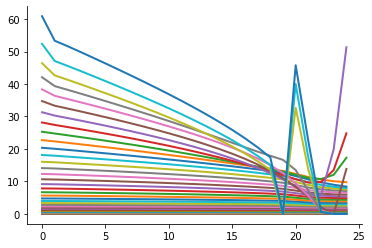

In [212]:
plt.plot(res_tech0_prd['ems'])
plt.show()

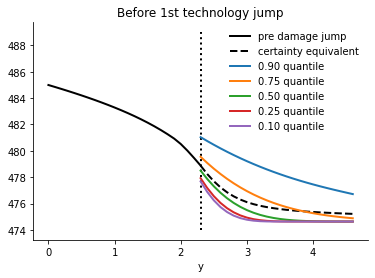

In [216]:
loc_k0 = np.abs(np.exp(k_grid) - k0).argmin()
loc_bar = np.abs(y_grid - y_bar).argmin()
v = res_tech0_prd['v0']
v_bound = res_tech0_prd['v_bound']
plt.plot(y_grid[:loc_bar+1], v[:loc_bar+1, loc_k0],
         color='black', label="pre damage jump")
plt.plot(y_grid[loc_bar:], v_bound[loc_bar:, loc_k0],
         color='black', linestyle='--', label='certainty equivalent')
quantile_list = [0.1, 0.25, 0.5, 0.75, 0.9]
v_tech = np.zeros((len(res_tech0), n_y, n_k))
args = (econ_param, dmg_param, climate_param, uncertain_param)
for i in range(len(res_tech1)):
    v_tech[i] = res_tech0[i]['v0']
for i in range(len(quantile_list)):
    plt.plot(y_grid[loc_bar:], np.quantile(v_tech[:, loc_bar:, loc_k0], quantile_list[4-i], axis=0),
             label="{:.2f} quantile".format(quantile_list[4-i]))

plt.vlines(y_bar, 474, 489, color='black', linestyle=':')
plt.title('Before 1st technology jump')
plt.xlabel('y')
plt.legend()
# plt.savefig('Phi_0.png', dpi=300)

In [219]:
np.exp(k_grid[loc_k0]), y_bar

(735.0951892419732, 2.3)

Text(0.5, 1.0, 'Pre damage jump, ϕ')

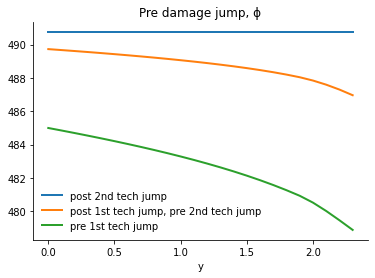

In [221]:
loc_k0 = np.abs(np.exp(k_grid) - k0).argmin()
loc_bar = np.abs(y_grid - y_bar).argmin()
v0 = res_tech0_prd['v0']
v1 = res_tech1_prd['v0']
v2 = res_tech2_prd['v0']

plt.plot(y_grid[:loc_bar+1], v2[:loc_bar+1, loc_k0], label="post 2nd tech jump")
plt.plot(y_grid[:loc_bar+1], v1[:loc_bar+1, loc_k0], label="post 1st tech jump, pre 2nd tech jump")
plt.plot(y_grid[:loc_bar+1], v0[:loc_bar+1, loc_k0], label="pre 1st tech jump")
plt.legend()
plt.xlabel('y')
plt.title('Pre damage jump, ϕ')
# plt.savefig('tech_jump.png', dpi=300)

# Simulation


Damage jump probability: $\mathcal{I}(y) dt$;

Technology jump probability: $\mathcal{I}_g dt$

## No jump simulation

In [229]:
ems = res_tech0_prd['ems']
y_grid[:len(ems)], ems.shape

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4]),
 (25, 51))

In [235]:
len(ems), y_grid_cap[-1], y_grid_cap, ems.shape, len(inv)

(25,
 2.4000000000000004,
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4]),
 (25, 51),
 25)

In [243]:
gridpoints = (y_grid_cap, k_grid)
# interpolate emission
e_func_r = GridInterp_2d(gridpoints, ems, 'Linear')

In [245]:
e_func([1.1, np.log(700), 0])

6.824516353838698

In [256]:
res = res_tech0_prd
r1 = 1.5
r2 = 2.5
y = 1.1
T = 80
dt = 1
pers = int(T/dt)
nDims = 3
ems = res['ems']
inv = res['inv']
y_grid_cap = y_grid[:len(ems)]
y_lower = 1.8
periods = int(T / dt)
gridpoints = (y_grid_cap, k_grid)
# interpolate emission
e_func_r = GridInterp_2d(gridpoints, ems, 'Linear')

def e_func(x):
    return e_func_r.get_value(x[0], x[1])  # match order

# interpolate investment
i_func_r = GridInterp_2d(gridpoints, inv, 'Linear')

def i_func(x):
    return i_func_r.get_value(x[0], x[1])

# drifts for each diffusion process
def compute_μlogk(x):
    return μk + i_func(x) - 0.5 * κ * i_func(x)**2 - 0.5 * σk**2

def compute_μy(E_x):
    return E_x * np.mean(θ_list)

def compute_μlogd(x, E_x):
    Y_x = x[0]
    dΛ = γ1 + γ2 * Y_x
    ddΛ = γ2
    return dΛ * compute_μy(E_x) + 0.5 * ddΛ * σy**2 * E_x**2

# initial points

K_0 = 80 / α
Y_0 = 1.1
logD_0 = -γ1 * Y_0 - 0.5 * γ2 * Y_0**2

hist = np.zeros([pers, nDims])
e_hist = np.zeros([pers])
i_hist = np.zeros([pers])
prob_hist = np.zeros([pers])

# initial points
hist[0, :] = [Y_0, np.log(K_0), logD_0]
e_hist[0] = e_func(hist[0, :])
i_hist[0] = i_func(hist[0, :])
y_t = hist[0,0]
I_y = r1 * (np.exp(r2 / 2 *
               (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
jump_prob = (I_y*dt) * (I_g*dt)
prob_hist[0] = 1 - jump_prob

for tm in range(1, pers):
    if hist[tm-1, 0] > y_bar:
        break
    # other periods
    else:
        e_hist[tm] = e_func(hist[tm-1, :])
        i_hist[tm] = i_func(hist[tm-1, :])
        hist[tm, 0] = hist[tm - 1, 0] + compute_μy(e_hist[tm - 1]) * dt  # Y
        hist[tm, 1] = hist[tm - 1, 1] + compute_μlogk(hist[tm - 1, :]) * dt  # logK
        hist[tm, 2] = hist[tm - 1, 2] + compute_μlogd(hist[tm - 1, :], e_hist[tm - 1]) * dt  # logDt
        y_t = hist[tm, 0]
        I_y = r1 * (np.exp(r2 / 2 * (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
        jump_prob = (I_y*dt) * (I_g*dt)
        prob_hist[tm] = 1 - jump_prob

#     if hist[tm, 0] > y_grid_cap[-1]:
#         break

e_k_ratio = e_hist / np.exp(hist[:, 1]) / α
iota_t = 1 - e_hist / np.exp(hist[:, 1]) / (α * λ_bar)
XK_t = α * θ_bar * iota_t**θ
MUe = θ * θ_bar / λ_bar * iota_t**(θ - 1)

simul = dict(e=e_hist, states=hist, ek_ratio=e_k_ratio, iota_t=iota_t, XK_t=XK_t, MUe=MUe)

In [282]:
hist[:,0]

array([1.1       , 1.11264993, 1.12529986, 1.13810791, 1.15107298,
       1.16419738, 1.17749502, 1.19096422, 1.20460326, 1.2184104 ,
       1.23238333, 1.24651909, 1.26081576, 1.27527143, 1.28988416,
       1.30465203, 1.31959043, 1.33469632, 1.34996564, 1.36539583,
       1.38098436, 1.39672861, 1.412626  , 1.42867387, 1.44486702,
       1.46120194, 1.47768783, 1.49432456, 1.51110886, 1.5280374 ,
       1.54510396, 1.56230354, 1.57963252, 1.59708728, 1.6146642 ,
       1.63235962, 1.65017193, 1.66810114, 1.6861429 , 1.70429285,
       1.7225466 , 1.74089799, 1.75933673, 1.77785804, 1.79645719,
       1.81512944, 1.83387264, 1.85266422, 1.87149288, 1.89035283,
       1.90923838, 1.92814387, 1.94701351, 1.96578862, 1.98446354,
       2.00303345, 2.0214938 , 2.03984124, 2.05804682, 2.07610513,
       2.09401136, 2.11176085, 2.12934914, 2.14681491, 2.1641737 ,
       2.18141841, 2.19854182, 2.21554591, 2.23243046, 2.24925193,
       2.26600844, 2.28269167, 2.29929338, 2.31580551, 0.     

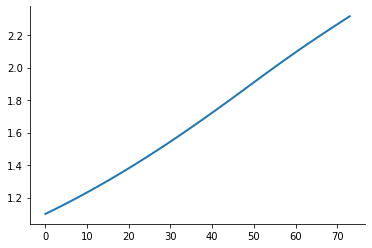

In [287]:
plt.plot(hist[:74, 0])
# plt.xlim(0, 72)

Text(0.5, 0, 'Years')

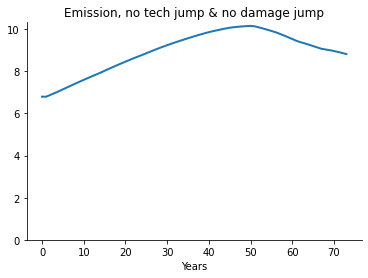

In [292]:
plt.plot(e_hist[:74])
# plt.xlim(0)
plt.ylim(0)
plt.title('Emission, no tech jump & no damage jump')
plt.xlabel('Years')

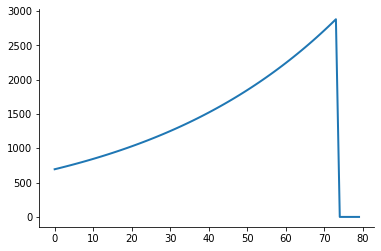

In [293]:
plt.plot(np.exp(hist[:,1]))

In [265]:
def no_jump_simul(res, dt=1, r1=1.5, r2=2.5):
    y = 1.1
    T = 130
    ems = res['ems']
    inv = res['inv']
    y_grid_cap = y_grid[:len(ems)]
    y_lower = 1.8
    periods = int(T / dt)
    gridpoints = (y_grid_cap, k_grid)
    # interpolate emission
    e_func_r = GridInterp_2d(gridpoints, ems, 'Linear')

    def e_func(x):
        return e_func_r.get_value(x[0], x[1])  # match order

    # interpolate investment
    i_func_r = GridInterp_2d(gridpoints, inv, 'Linear')

    def i_func(x):
        return i_func_r.get_value(x[0], x[1])

    # drifts for each diffusion process
    def compute_μlogk(x):
        return μk + i_func(x) - 0.5 * κ * i_func(x)**2 - 0.5 * σk**2

    def compute_μy(E_x):
        return E_x * np.mean(θ_list)

    def compute_μlogd(x, E_x):
        Y_x = x[0]
        dΛ = γ1 + γ2 * Y_x
        ddΛ = γ2
        return dΛ * compute_μy(E_x) + 0.5 * ddΛ * σy**2 * E_x**2

    # initial points

    K_0 = 80 / α
    Y_0 = 1.1
    logD_0 = -γ1 * Y_0 - 0.5 * γ2 * Y_0**2

    hist = np.zeros([pers, nDims])
    e_hist = np.zeros([pers])
    i_hist = np.zeros([pers])

    for tm in range(pers):
        if tm == 0:
            # initial points
            hist[0, :] = [Y_0, np.log(K_0), logD_0]
            e_hist[0] = e_func(hist[0, :])
            i_hist[0] = i_func(hist[0, :])

        else:
            # other periods
            hist[tm, 0] = hist[tm - 1, 0] + compute_μy(e_hist[tm - 1]) * dt  # Y
            hist[tm, 1] = hist[tm - 1, 1] + compute_μlogk(hist[tm - 1, :]) * dt  # logK
            hist[tm, 2] = hist[tm - 1, 2] + compute_μlogd(hist[tm - 1, :], e_hist[tm - 1]) * dt  # logDt
            e_hist[tm] = e_func(hist[tm-1, :])
            i_hist[tm] = i_func(hist[tm-1, :])
            
        if hist[tm, 0] > y_grid_cap[-1]:
            break

    e_k_ratio = e_hist / np.exp(hist[:, 1]) / α
    iota_t = 1 - e_hist / np.exp(hist[:, 1]) / (α * λ_bar)
    XK_t = α * θ_bar * iota_t**θ
    MUe = θ * θ_bar / λ_bar * iota_t**(θ - 1)

    simul = dict(e=e_hist, states=hist, ek_ratio=e_k_ratio, iota_t=iota_t, XK_t=XK_t, MUe=MUe)
    return simul

In [295]:
simul = no_jump_simul(res_tech0_prd,)

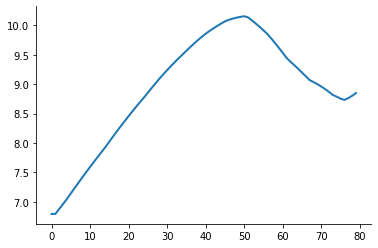

In [296]:
plt.plot(simul['e'])

In [306]:
np.random.binomial(1, p=I_g_1)

0

In [321]:
# jump simulation, no damage jump and tech jump
def simul_one_path(i, T):
    np.random.seed(i)
    I_g_1 = 1 / 80
    I_g_2 = 1 / 60
    res0 = res_tech0_prd
    res1 = res_tech1_prd
    res2 = res_tech2_prd
    r1 = 1.5
    r2 = 2.5
    y = 1.1
#     T = 40
    dt = 1
    pers = int(T / dt)
    nDims = 3
    ems0 = res0['ems']
    inv0 = res0['inv']
    ems1 = res1['ems']
    inv1 = res1['inv']
    ems2 = res2['ems']
    inv2 = res2['inv']
    y_grid_cap = y_grid[:len(ems)]
    y_lower = 1.8
    periods = int(T / dt)
    gridpoints = (y_grid_cap, k_grid)

    # interpolate emission
    # e_func_r = GridInterp_2d(gridpoints, ems0, 'Linear')
    def e_func(x, ems):
        e_interp = GridInterp_2d(gridpoints, ems, 'Linear')
        return e_interp.get_value(x[0], x[1])  # match order


    # interpolate investment
    # i_func_r = GridInterp_2d(gridpoints, inv, 'Linear')
    def i_func(x, inv):
        i_func_r = GridInterp_2d(gridpoints, inv, 'Linear')
        return i_func_r.get_value(x[0], x[1])


    # drifts for each diffusion process
    def compute_μlogk(x, inv):
        return μk + i_func(x, inv) - 0.5 * κ * i_func(x, inv)**2 - 0.5 * σk**2


    def compute_μy(E_x):
        return E_x * np.mean(θ_list)


    def compute_μlogd(x, E_x):
        Y_x = x[0]
        dΛ = γ1 + γ2 * Y_x
        ddΛ = γ2
        return dΛ * compute_μy(E_x) + 0.5 * ddΛ * σy**2 * E_x**2


    # initial points

    K_0 = 80 / α
    Y_0 = 1.1
    logD_0 = γ1 * Y_0 + 0.5 * γ2 * Y_0**2

    tech_state = 0
    hist = np.zeros([pers, nDims])
    e_hist = np.zeros([pers])
    i_hist = np.zeros([pers])
    prob_hist = np.zeros([pers])

    # initial points
    hist[0, :] = [Y_0, np.log(K_0), logD_0]
    e_hist[0] = e_func(hist[0, :], ems0)
    i_hist[0] = i_func(hist[0, :], inv0)
    y_t = hist[0, 0]
    I_y = r1 * (np.exp(r2 / 2 * (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
    jump_prob = (1 - I_y * dt) * (I_g_1 * dt)
    prob_hist[0] = 1 - jump_prob


    I_g = I_g_1
    for tm in range(1, pers):
        if hist[tm - 1, 0] > y_bar:
            break
        # other periods
        else:
            # state 0
            if tech_state == 0:
                I_g = I_g_1
                tech_jump = np.random.binomial(1, p=I_g)
                if tech_jump == 0:
                    ems_grid = ems0
                    inv_grid = inv0
                elif tech_jump == 1:
                    ems_grid = ems1
                    inv_grid = inv1
                    tech_state = 1
            # state 1
            elif tech_state == 1:
                I_g = I_g_2
                tech_jump = np.random.binomial(1, p=I_g)
                if tech_jump == 0:
                    ems_grid = ems1
                    inv_grid = inv1
                elif tech_jump == 1:
                    ems_grid = ems2
                    inv_grid = inv2
                    tech_state = 2
            # state 2
            elif tech_state == 2:
                ems_grid = ems2
                inv_grid = inv2

            e_hist[tm] = e_func(hist[tm - 1, :], ems_grid)
            i_hist[tm] = i_func(hist[tm - 1, :], inv_grid)
            hist[tm, 0] = hist[tm - 1, 0] + compute_μy(e_hist[tm - 1]) * dt  # Y
            hist[tm, 1] = hist[tm - 1, 1] + compute_μlogk(hist[tm - 1, :], inv_grid) * dt  # logK
            hist[tm, 2] = hist[tm - 1, 2] + compute_μlogd(hist[tm - 1, :], e_hist[tm - 1]) * dt  # logDt
    #     if hist[tm, 0] > y_grid_cap[-1]:
    #         break

    e_k_ratio = e_hist / np.exp(hist[:, 1]) / α
    iota_t = 1 - e_hist / np.exp(hist[:, 1]) / (α * λ_bar)
    XK_t = α * θ_bar * iota_t**θ
    MUe = θ * θ_bar / λ_bar * iota_t**(θ - 1)

    simul = dict(e=e_hist,
                 states=hist,
                 ek_ratio=e_k_ratio,
                 iota_t=iota_t,
                 XK_t=XK_t,
                 MUe=MUe)
    return simul

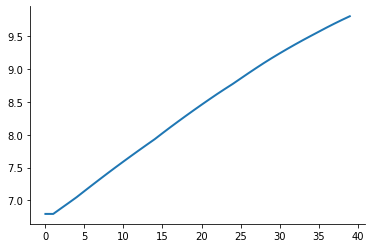

In [331]:
plt.plot(e_hist)

In [346]:
N = 100_000
T = 60
arg = [(i, 60) for i in range(N)]
with Pool() as p:
    simul_list = p.starmap(simul_one_path, arg)

In [348]:
T = 60
ems_mat = np.zeros((T, len(simul_list)))
for itr in range(len(simul_list)):
    ems_mat[:, itr] = simul_list[itr]['e']

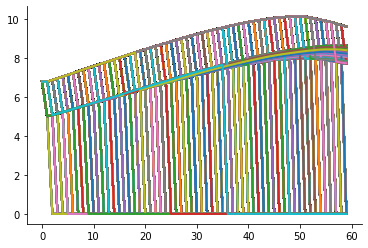

In [349]:
plt.plot(ems_mat)
plt.show()

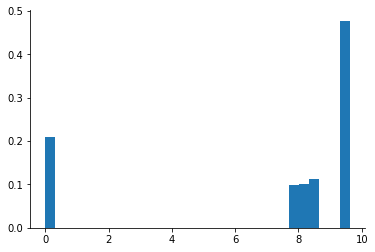

In [351]:
plt.hist(ems_mat[-1], weights=np.ones_like(ems_mat[-1])/len(ems_mat[-1]), bins=30)
plt.show()

In [352]:
np.unique(ems_mat[-1], return_counts=True)

(array([0.        , 7.71806742, 7.71874381, 7.73753591, 7.75652806,
        7.77548234, 7.79461813, 7.81394797, 7.83344299, 7.85308596,
        7.87273566, 7.89226176, 7.91169473, 7.93106037, 7.95032906,
        7.96946466, 7.98847566, 8.00744474, 8.02578364, 8.04341268,
        8.06095891, 8.07843977, 8.09580679, 8.11307014, 8.13022353,
        8.14729799, 8.16427013, 8.18116164, 8.19796894, 8.21471365,
        8.23137668, 8.24794975, 8.26442386, 8.28079897, 8.29709383,
        8.31327978, 8.32936415, 8.34535284, 8.36127325, 8.37710136,
        8.39283076, 8.40845301, 8.42396886, 8.43937581, 8.45466804,
        8.46984754, 8.48490725, 8.49985883, 8.51152149, 8.52247548,
        8.53335178, 8.54414418, 8.55484902, 8.56546361, 8.5759872 ,
        8.58642583, 8.59677021, 8.60702665, 8.61719261, 8.62726836,
        9.61692218]),
 array([20988,   585,   616,   579,   562,   601,   570,   606,   592,
          589,   580,   531,   583,   560,   556,   564,   596,   565,
          549,   569